### Все выполнялось в google colab, для корректного выполнения кода необходимо загрузить данные в google drive и прокинуть токен, во время выполнения первой ячейки.

In [1]:
!pip install eo-learn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import matplotlib.pyplot as plt

import torchvision 
import torch.nn as nn
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from pathlib import Path
from read_data1 import load_numpy_gz, load_pickle_gz, read_image, read_timestamp, show_rgb, read_bbox, read_mask_scl
from IPython.display import clear_output
clear_output()

from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [269]:
!nvidia-smi

Fri Dec  3 16:29:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    35W / 250W |   2887MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [139]:
# !rm -r data
# !rm -r test_data

rm: cannot remove 'test_data': No such file or directory


In [7]:
# !rm -r test_data/no_spill
# !rm -r test_data/spill


In [140]:
!mkdir data
!mkdir data/spill
!mkdir data/no_spill

!mkdir val_data
!mkdir val_data/spill
!mkdir val_data/no_spill

!mkdir raw_data


!mkdir raw_test_data
!mkdir test_data
!mkdir test_data/unknown

mkdir: cannot create directory ‘val_data’: File exists
mkdir: cannot create directory ‘val_data/spill’: File exists
mkdir: cannot create directory ‘val_data/no_spill’: File exists
mkdir: cannot create directory ‘raw_data’: File exists
mkdir: cannot create directory ‘raw_test_data’: File exists


In [294]:
spill_dir = Path('/content/gdrive/MyDrive/GoodDay/spill')
no_spill_dir = Path('/content/gdrive/MyDrive/GoodDay/no_spill')

test_data_dir = Path('/content/gdrive/MyDrive/GoodDay/test')

for archive in tqdm(spill_dir.glob('*.zip')):
    shutil.unpack_archive(archive, './raw_data/spill/')

for archive in tqdm(no_spill_dir.glob('*.zip')):
    shutil.unpack_archive(archive, './raw_data/no_spill/')

for archive in tqdm(test_data_dir.glob('*.zip')):
    shutil.unpack_archive(archive, './test_data/')

In [295]:
from sklearn.model_selection import train_test_split

save_spill_dir = Path('/content/data/spill')
save_spill_dir_val = Path('/content/val_data/spill')

skip_counter = 0

for date_dir in Path('raw_data/spill/').glob("*"):
    train_files, val_files = train_test_split(list(date_dir.glob("*")), test_size=0.2, random_state=142)

    for image in tqdm(train_files):
        try:
            imgs = read_image(image)
        except:
            skip_counter += 1
            continue
        for img in imgs:
            if (img[:,:,[3, 2, 1]].sum(axis=-1) > 2.8).sum() > 4096*0.7:
                continue
            np.save(save_spill_dir / f"{date_dir.stem}_{image.stem}.npy",
                    (np.clip(img[:,:,[3, 2, 1]], 0.,1.)*255).astype(np.uint8))
    
    for image in tqdm(val_files):
        try:
            imgs = read_image(image)
        except:
            skip_counter += 1
            continue
        for img in imgs:
            if (img[:,:,[3, 2, 1]].sum(axis=-1) > 2.8).sum() > 4096*0.7:
                continue
            np.save(save_spill_dir_val / f"{date_dir.stem}_{image.stem}.npy",
                    (np.clip(img[:,:,[3, 2, 1]], 0.,1.)*255).astype(np.uint8))


print(f'{skip_counter} dirs were skipped')

In [296]:
save_no_spill_dir = Path('/content/data/no_spill')
save_no_spill_dir_val = Path('/content/val_data/no_spill')

add_path_no_spill = 'sentinel2-l2a/patches/64x64-10/2021'
skip_counter = 0

for date_dir in Path('raw_data/no_spill/').glob("*"):
    train_files, val_files = train_test_split(list(date_dir.glob("*")), test_size=0.2, random_state=142)

    for image in tqdm(train_files):
        
        try:
            imgs = read_image(image / add_path_no_spill)
        except:
            skip_counter += 1
            continue

        for img in imgs:
            np.save(save_no_spill_dir / f"{date_dir.stem}_{image.stem}.npy",
                    (np.clip(img[:,:,[3, 2, 1]], 0.,1.)*255).astype(np.uint8))

    for image in tqdm(val_files):
        
        try:
            imgs = read_image(image / add_path_no_spill)
        except:
            skip_counter += 1
            continue

        for img in imgs:
            np.save(save_no_spill_dir_val / f"{date_dir.stem}_{image.stem}.npy",
                    (np.clip(img[:,:,[3, 2, 1]], 0.,1.)*255).astype(np.uint8))

print(f'\n {skip_counter} dirs were skipped')

In [309]:
save_test_dir = Path('/content/test_data/unknown/')

add_path_no_spill = 'sentinel2-l2a/patches/64x64-10/2021'
skip_counter = 0

for date_dir in Path('raw_test_data/').glob("*"):
    for image in tqdm(list(date_dir.glob("*"))):
        try:
            imgs = read_image(image / add_path_no_spill)
        except:
            skip_counter += 1
            continue
        for img in imgs:
            if (img[:,:,[3, 2, 1]].sum(axis=-1) > 2.8).sum() > 4096*0.7:
                continue
            np.save(save_test_dir / f"{date_dir.stem}_{image.stem}.npy",
                    (np.clip(img[:,:,[3, 2, 1]], 0.,1.)*255).astype(np.uint8))

print(f'\n {skip_counter} dirs were skipped')

In [144]:
import torchvision.transforms as transforms

loader = lambda x: np.load(x)
is_valid = lambda x: True

transform = transforms.Compose([
            transforms.ToPILImage(), 
            transforms.Resize([224,224]), 
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

val_transform = transforms.Compose([
            transforms.ToPILImage(), 
            transforms.Resize([224,224]), 
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

batch_size = 16

dataset = ImageFolder('./data', loader=loader, is_valid_file=is_valid, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageFolder('./data', loader=loader, is_valid_file=is_valid, transform=transform)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

In [145]:
from sklearn.metrics import accuracy_score

DEVICE = 'cuda'

def trainer(model, optimizer, criterion, dataloader_tr, dataloader_val, epochs, name):
    history = {'loss': [], 'val_loss': [], 'accuracy_score':[], 'val_accuracy_score':[]}
    wait_best = 0
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4)
    for epoch in range(epochs):
        cur_epoch_loss = 0.
        cur_accuracy_score = 0.
        cur_epoch_val_loss = 0.
        cur_val_f1_score = 0.
        all_preds = []
        all_true = []
        model.train()
        for X_batch, Y_batch in tqdm(dataloader_tr, position=0):
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE).unsqueeze(1)

            optimizer.zero_grad()
            y_pred = torch.sigmoid(model(X_batch.float()))
            loss = criterion(y_pred, Y_batch.float())
            loss.backward()
            optimizer.step()

            all_preds.extend(y_pred.cpu().detach().numpy().tolist())
            all_true.extend(Y_batch.cpu().detach().numpy().tolist())

            cur_epoch_loss += loss.item() * X_batch.size(0)

        cur_accuracy_score = accuracy_score(all_true, (np.array(all_preds) > 0.5).astype(int))
        all_true.clear()
        all_preds.clear()
        history['loss'].append(cur_epoch_loss / len(dataloader_tr))
        history['accuracy_score'].append(cur_accuracy_score)


        model.eval()
        with torch.no_grad():
            for X_batch, Y_batch in tqdm(dataloader_val, position=0):
                X_batch = X_batch.to(DEVICE)
                Y_batch = Y_batch.to(DEVICE).unsqueeze(1)

                y_pred = torch.sigmoid(model(X_batch.float()))
                loss = criterion(y_pred, Y_batch.float())

                all_preds.extend(y_pred.cpu().detach().numpy().tolist())
                all_true.extend(Y_batch.cpu().detach().numpy().tolist())

                cur_epoch_val_loss += loss.item() * X_batch.size(0)

        accuracy_score_val = accuracy_score(all_true, (np.array(all_preds) > 0.5).astype(int))
        history['val_loss'].append(cur_epoch_val_loss / len(dataloader_val))
        history['val_accuracy_score'].append(accuracy_score_val)

        clear_output(wait=True)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        ax[0].plot(history['loss'], label='loss')
        ax[0].plot(history['val_loss'], label='val_loss')
        ax[0].legend()

        ax[1].plot(history['accuracy_score'], label='accuracy')
        ax[1].plot(history['val_accuracy_score'], label='val_accuracy')
        ax[1].legend()
        plt.show()
        print(f'\n[{name}-{epoch}] loss=%.3f val_loss=%.3f accuracy_score=%.5f val_accuracy_score=%.5f' % (history['loss'][-1], history['val_loss'][-1], history['accuracy_score'][-1], history['val_accuracy_score'][-1]))

        if len(history['val_loss']) == 1 or history['val_loss'][-1] < min(history['val_loss'][:-1]):
            print('Saving new best model')
            torch.save(model.state_dict(), f'/content/gdrive/MyDrive/GoodDay/models/best_loss_{name}.st')
            wait = 0
        else:
             wait += 1

        if len(history['val_accuracy_score']) == 1 or history['val_accuracy_score'][-1] > max(history['val_accuracy_score'][:-1]):
            print('Saving new best accuracy_score model')
            torch.save(model.state_dict(), f'/content/gdrive/MyDrive/GoodDay/models/best_acc_{name}.st')
        
        if wait >= 9:
            break

        scheduler.step(history['val_loss'][-1])

    return history
            

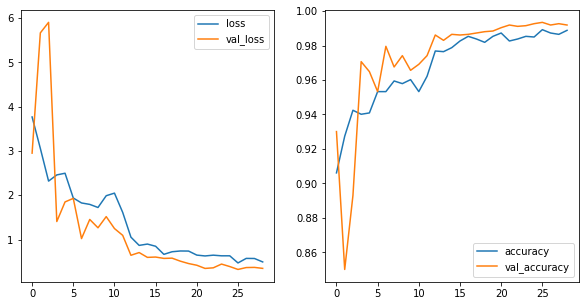


[rn18-28] loss=0.496 val_loss=0.351 accuracy_score=0.98879 val_accuracy_score=0.99189


 12%|█▏        | 20/162 [00:01<00:10, 14.03it/s]


KeyboardInterrupt: ignored

In [146]:
MAX_EPOCHS = 50

model = torchvision.models.resnet18(True)
model.fc = nn.Linear(512, 1)
model = model.cuda()
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

history = trainer(model, optimizer, loss_func, dataloader, val_dataloader, MAX_EPOCHS, f'rn18')

In [ ]:
from PIL import Image

import torchvision 
import torch.nn as nn
import torchvision.transforms as transforms

In [310]:
inference_transform = transforms.Compose([
            transforms.ToPILImage(), 
            transforms.Resize([224,224]), 
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])


model = torchvision.models.resnet18(True)
model.fc = nn.Linear(512, 1)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/GoodDay/models/best_loss_rn18.st'))
model.eval()

batch_size = 16

dataset_ts = ImageFolder('./test_data/', loader=loader, is_valid_file=is_valid, transform=inference_transform)
dataloader_ts = DataLoader(dataset=dataset_ts, batch_size=batch_size, shuffle=False)

dataset_clear = ImageFolder('./test_data/', loader=loader, is_valid_file=is_valid)
dataloader_clear = DataLoader(dataset=dataset_clear, batch_size=batch_size, shuffle=False)

preds = []
imgs = []
true = []
model.cuda()
with torch.no_grad():
    for X_batch, y_batch in tqdm(dataloader_ts, position=0):
        # imgs.append(X_batch[0].numpy().transpose((1, 2, 0))
        X_batch = X_batch.to(DEVICE)
        pred = torch.sigmoid(model(X_batch.float()))
        preds.append(pred.cpu().detach().numpy()[0][0])

for X_batch, y_batch in tqdm(dataloader_clear, position=0):
    imgs.append(X_batch[0].numpy())
    true.append(y_batch[0].numpy())

100%|██████████| 116/116 [00:00<00:00, 146.84it/s]


## DETECTION TEST

j = 35
j = 40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


j = 95
j = 97
j = 111


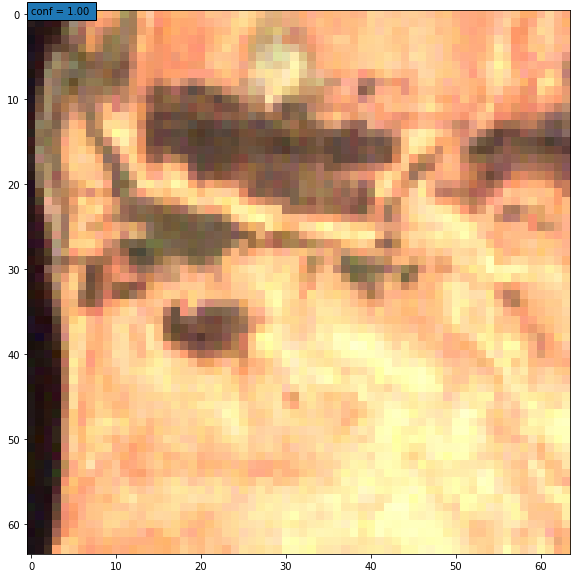

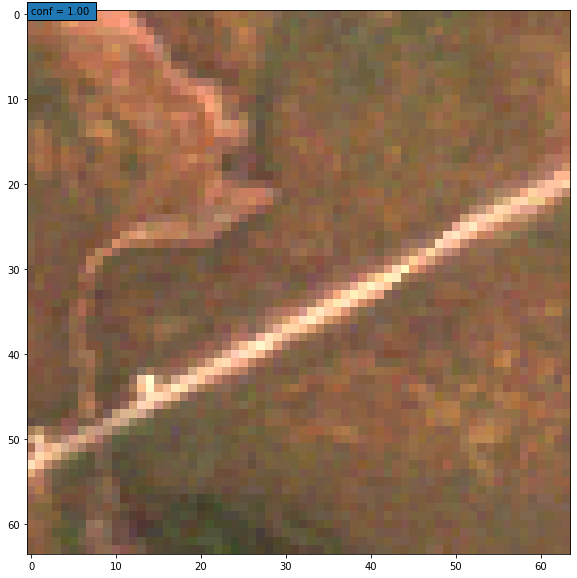

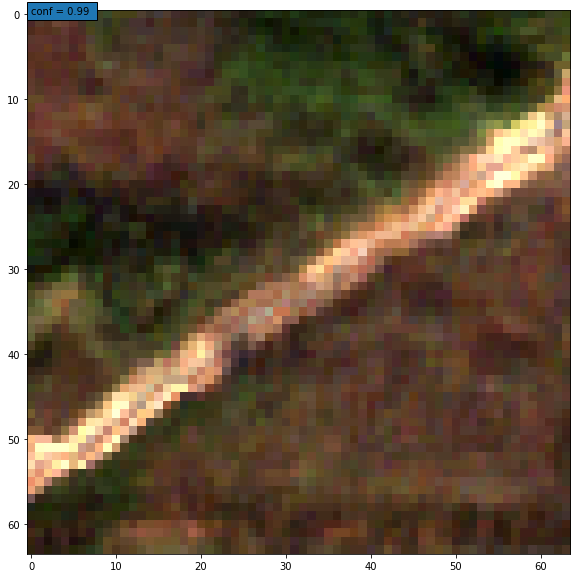

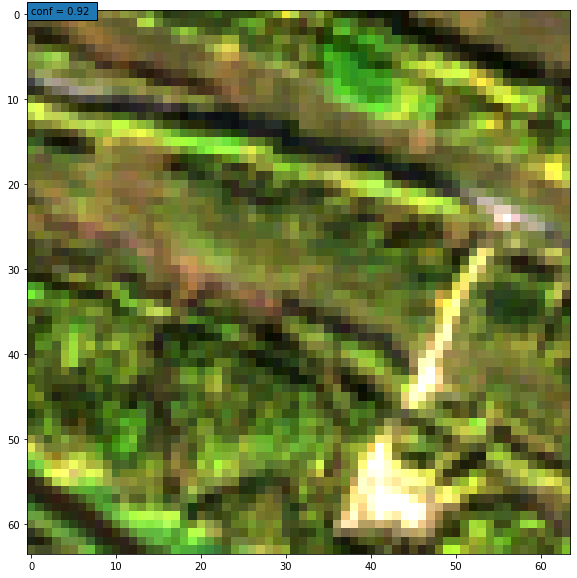

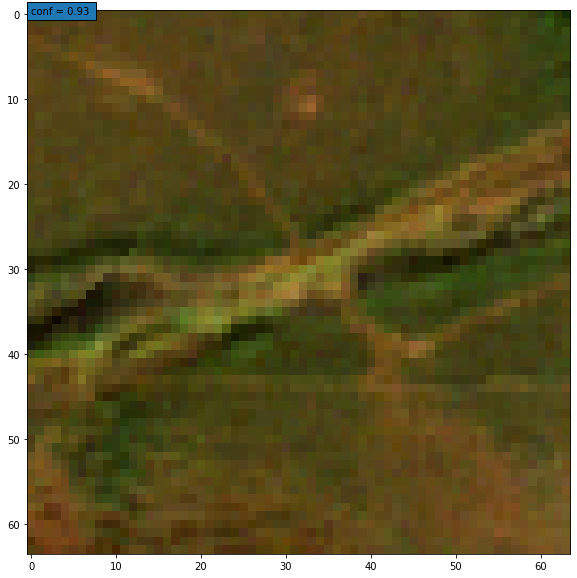

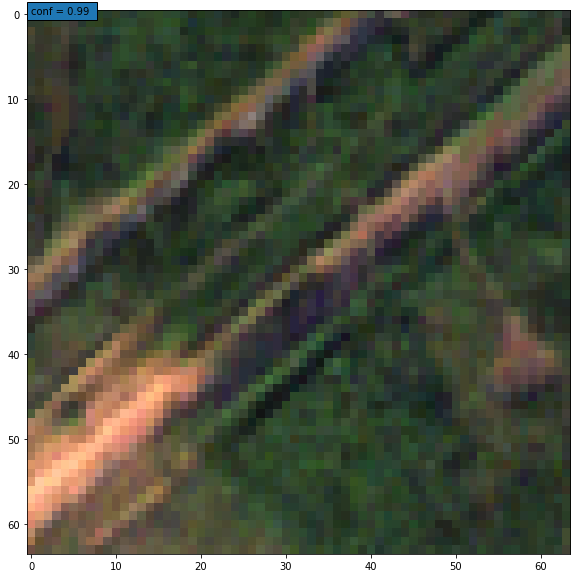

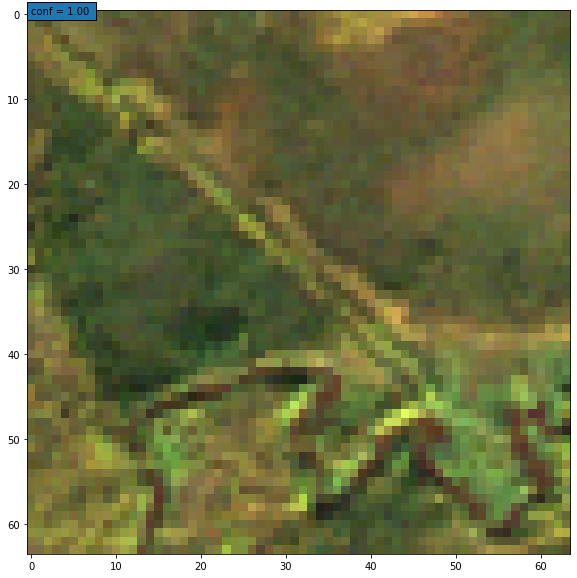

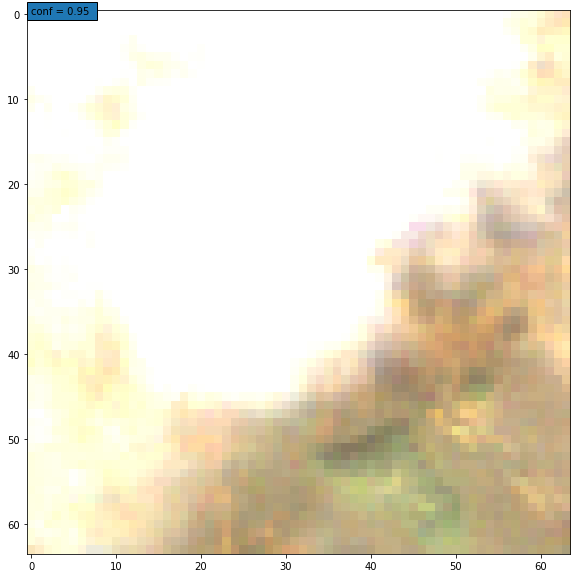

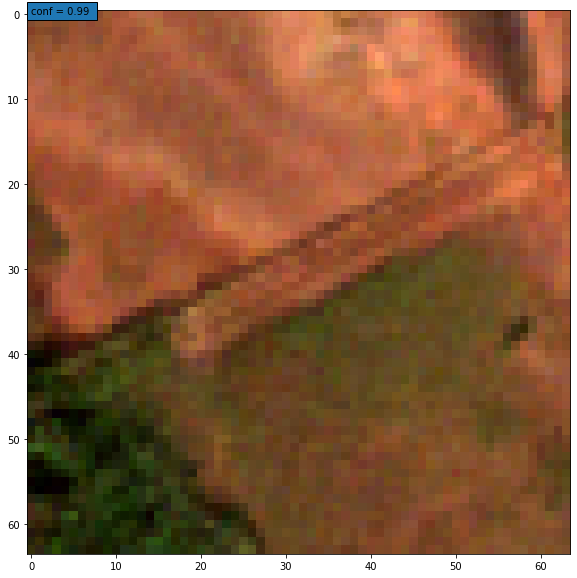

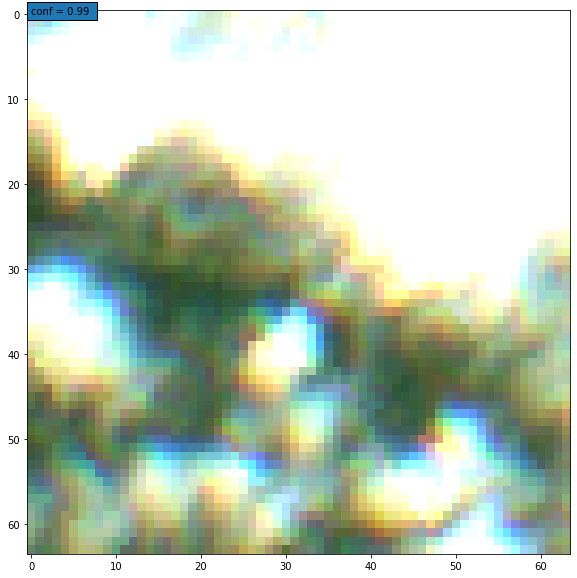

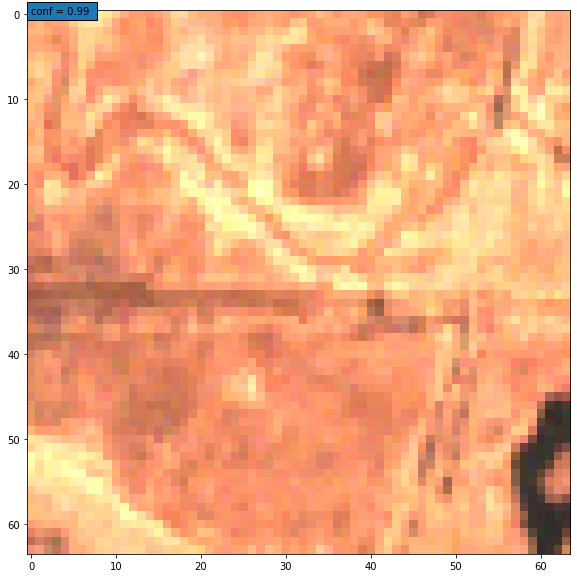

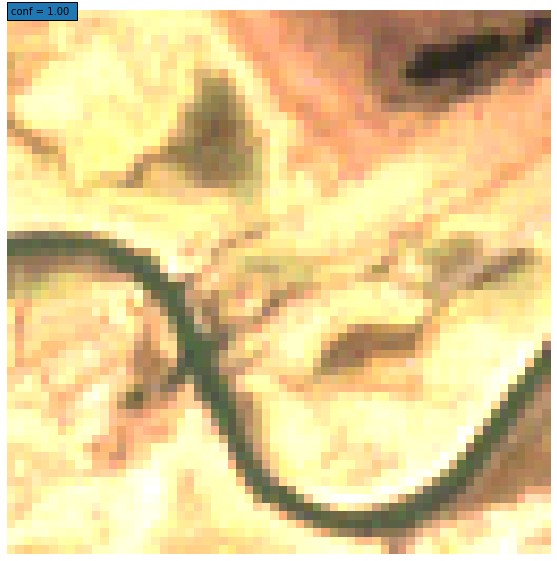

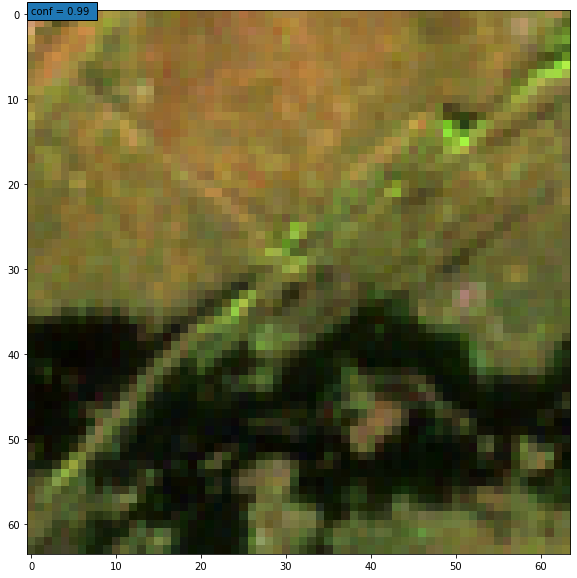

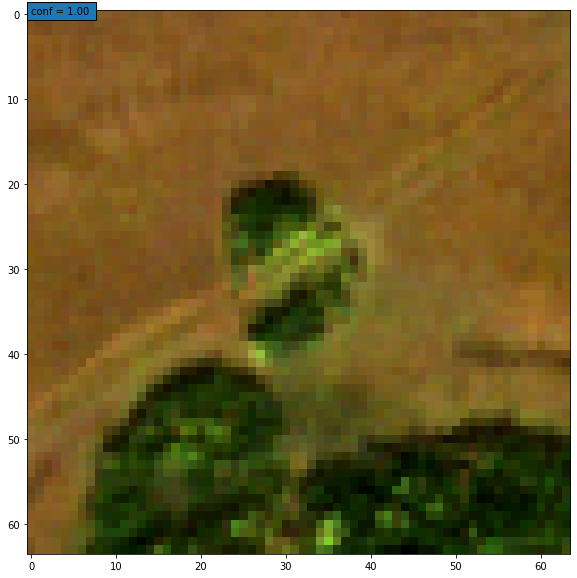

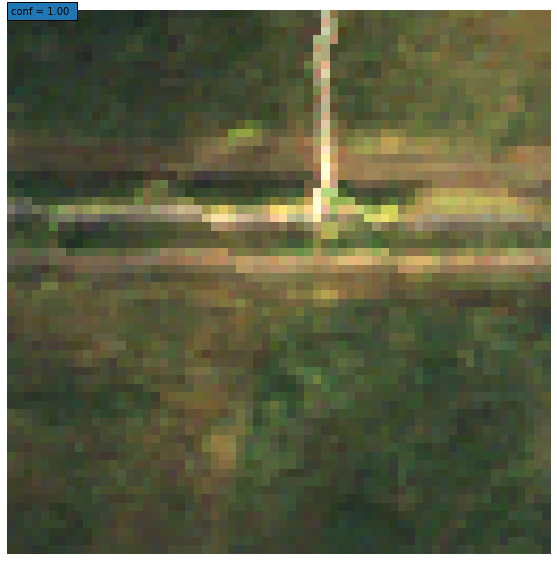

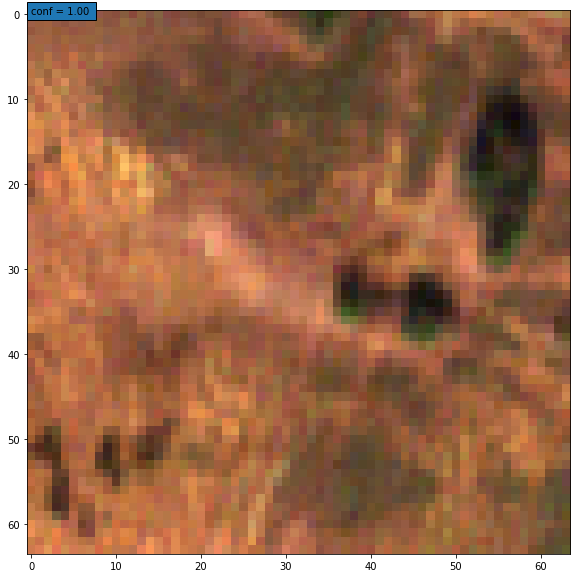

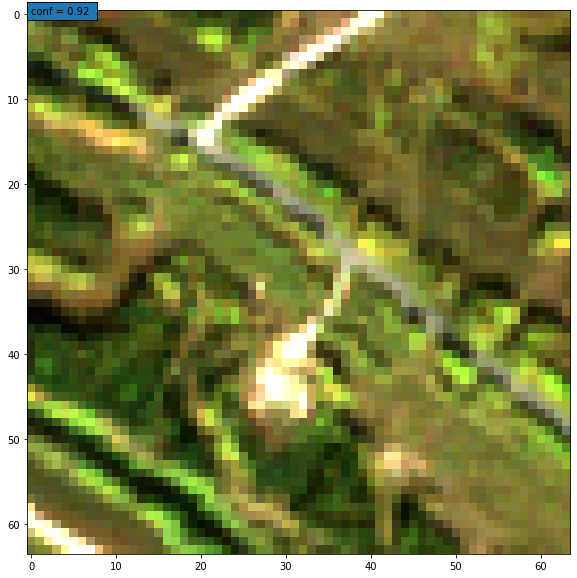

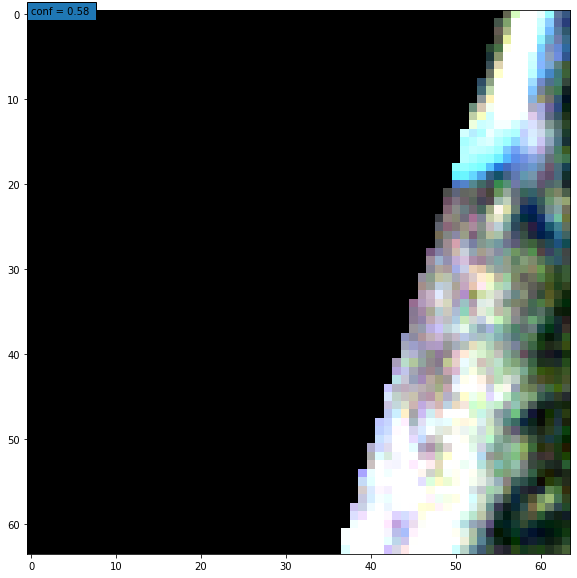

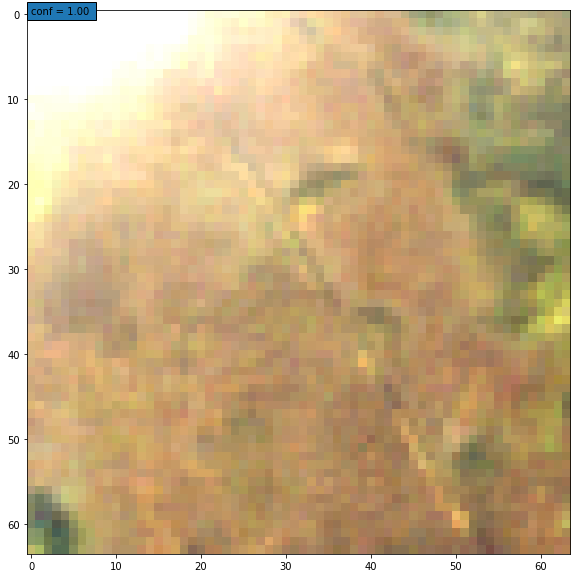

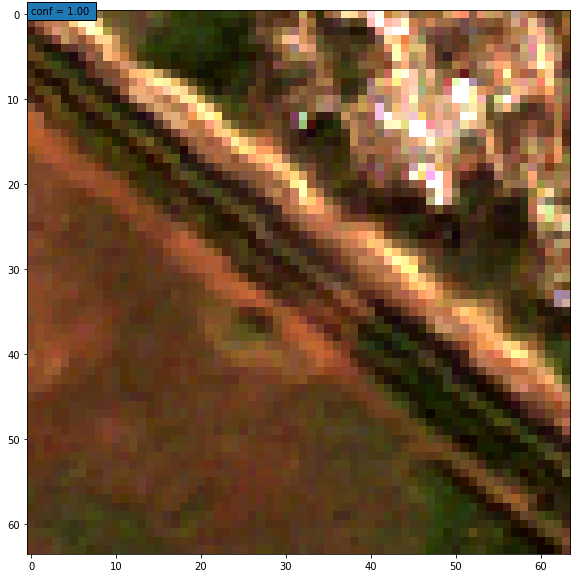

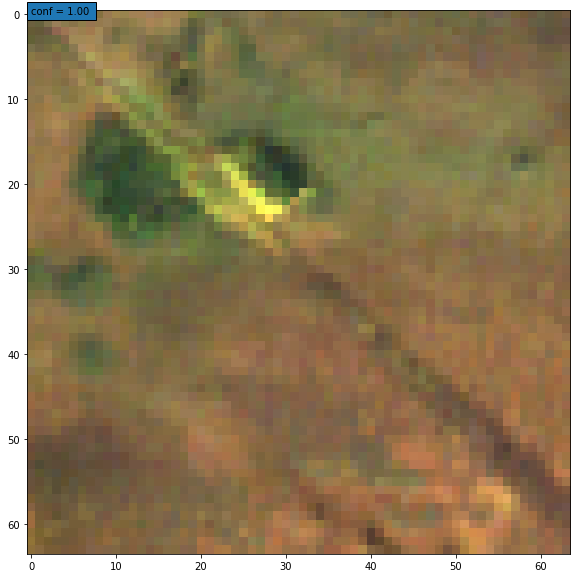

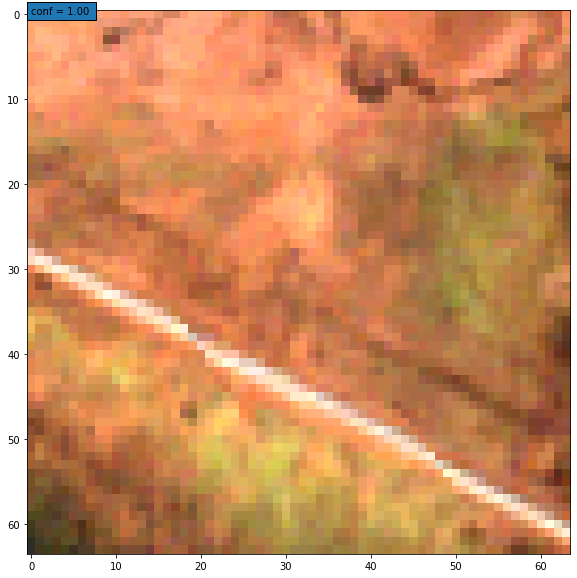

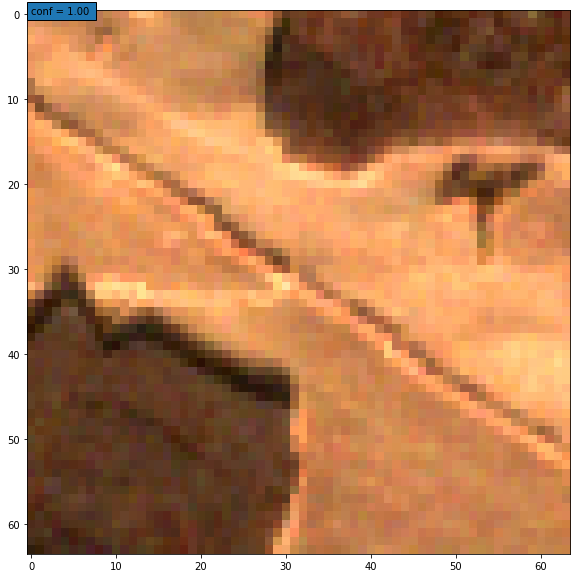

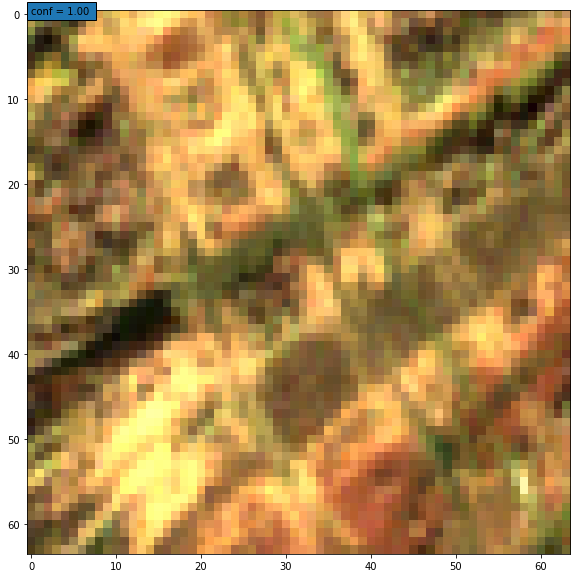

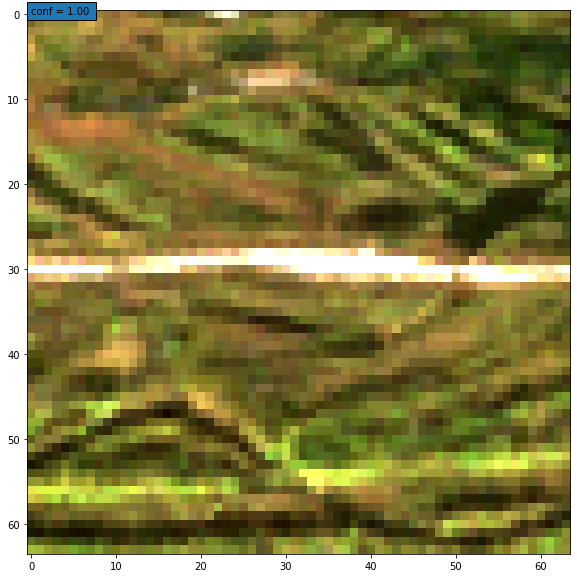

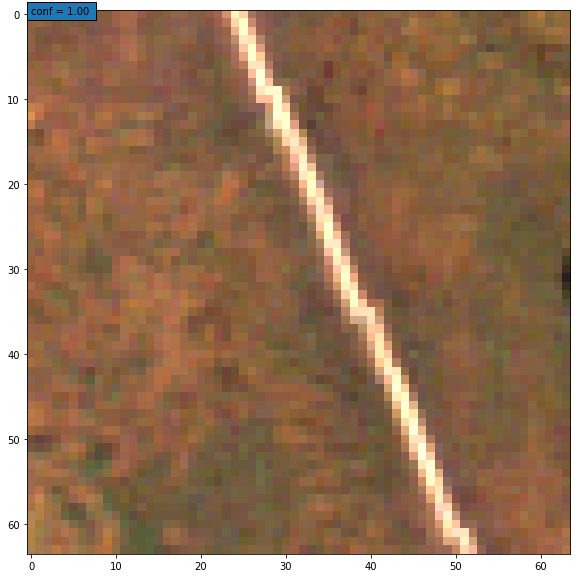

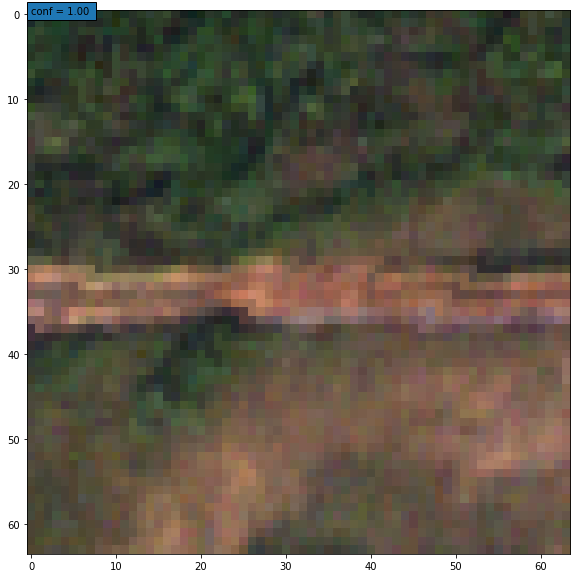

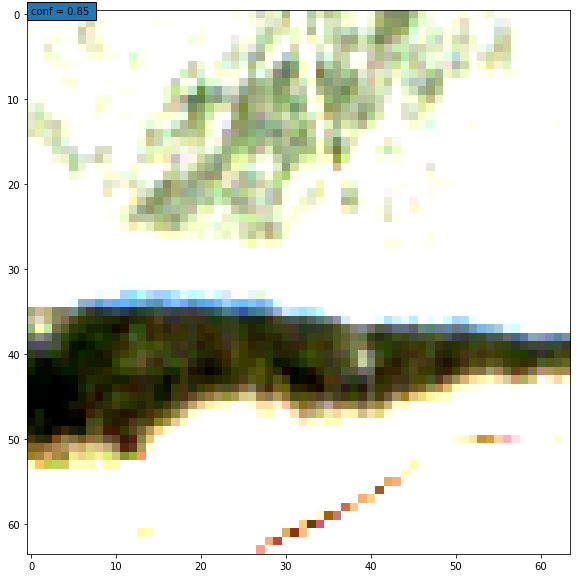

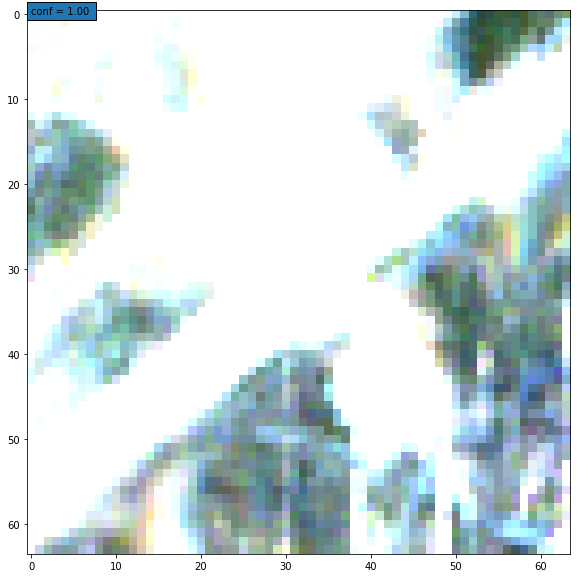

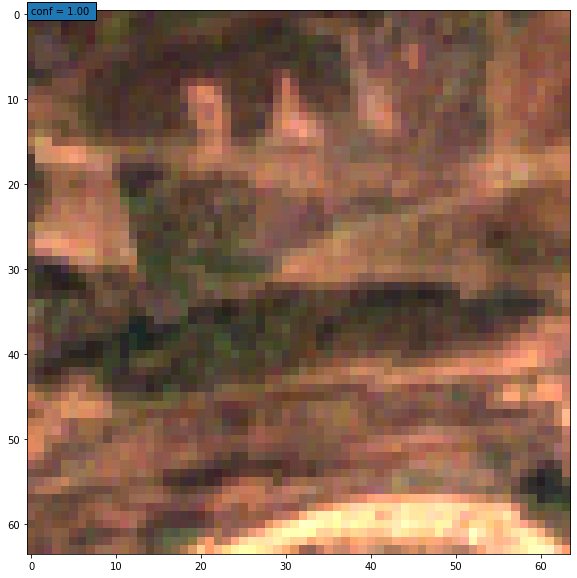

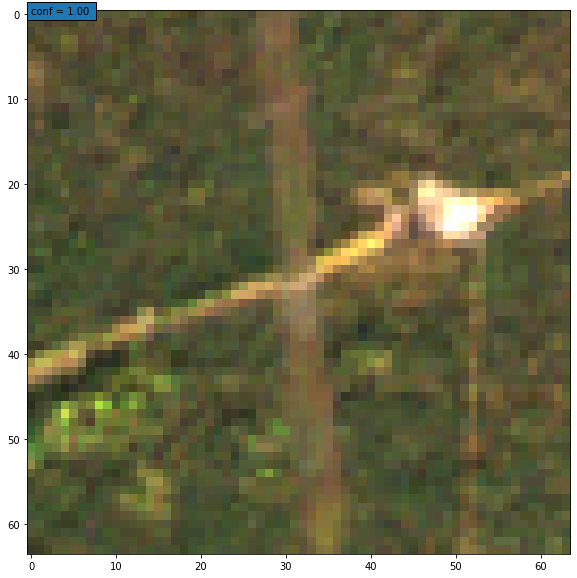

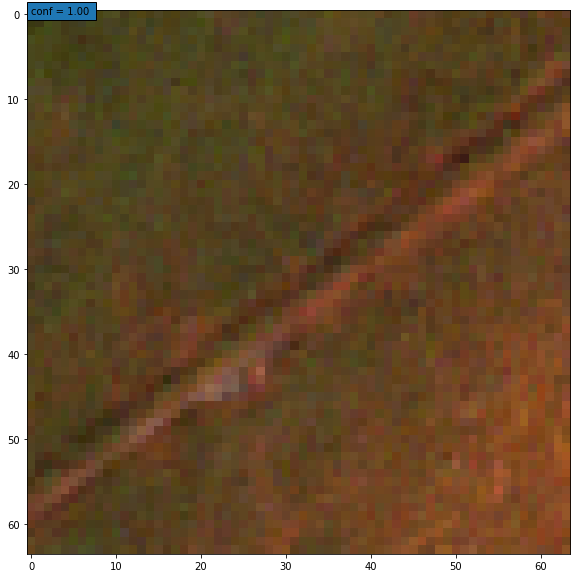

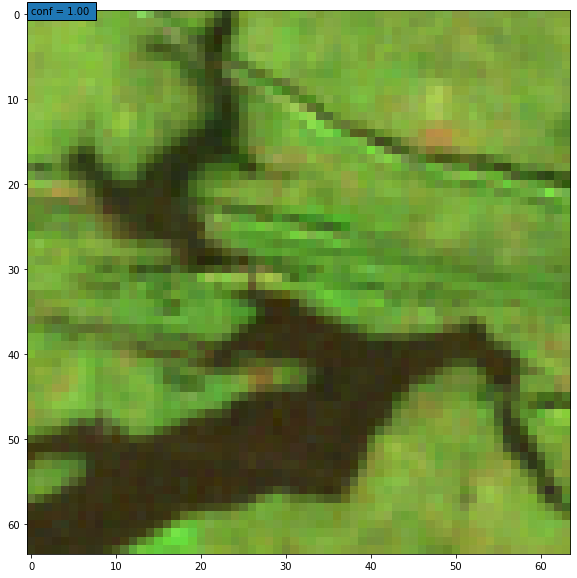

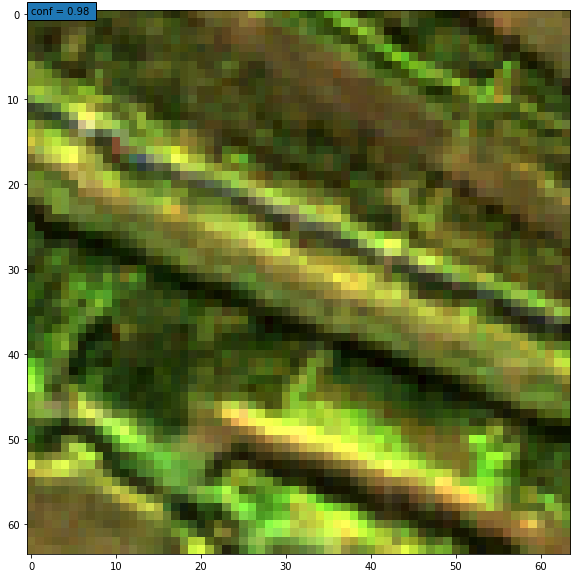

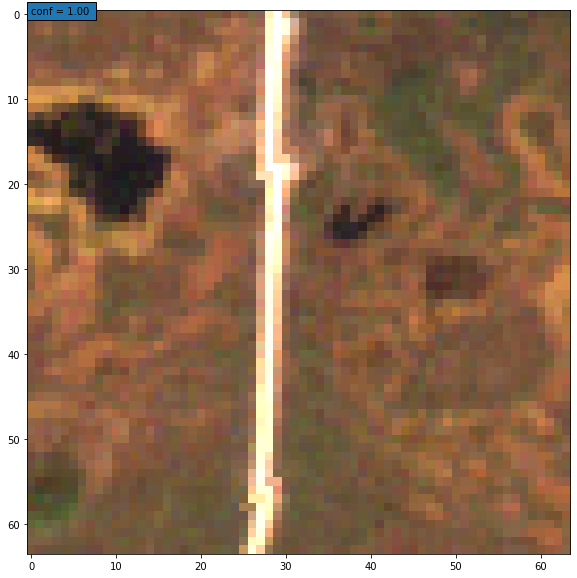

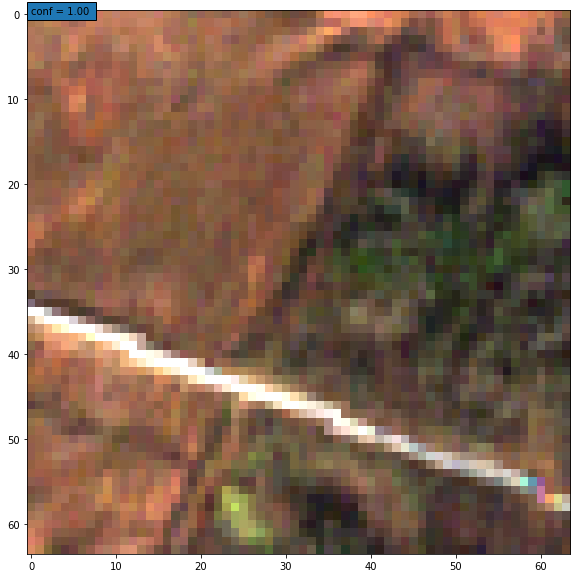

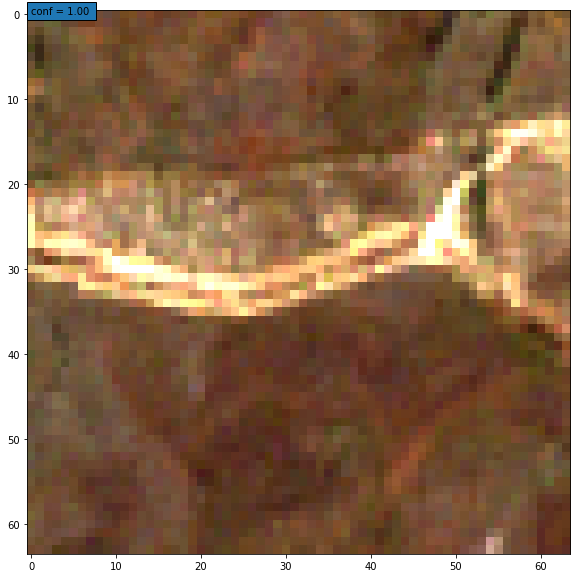

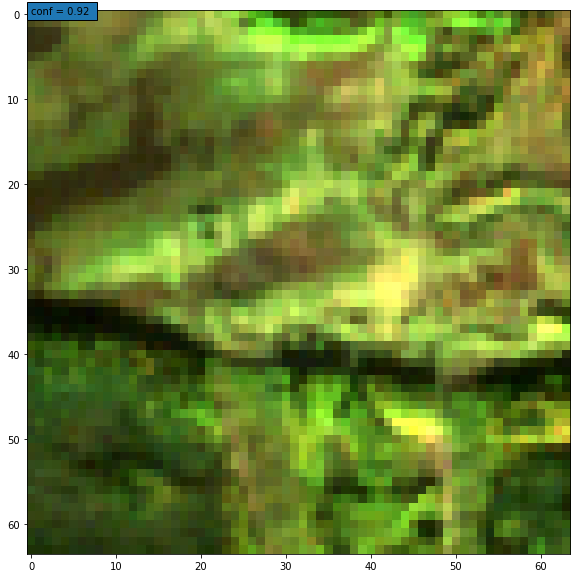

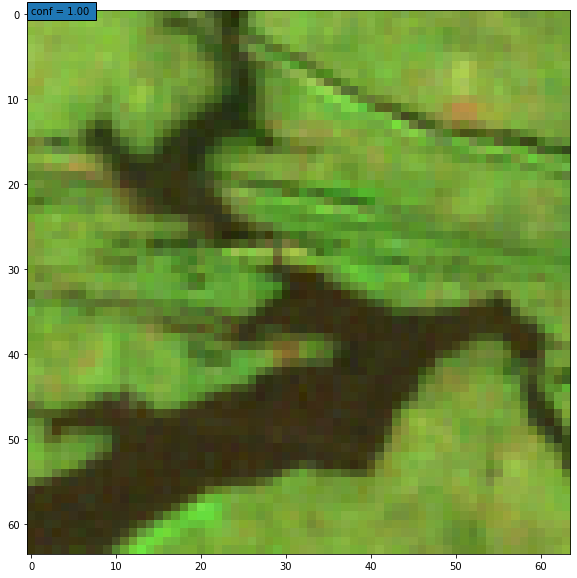

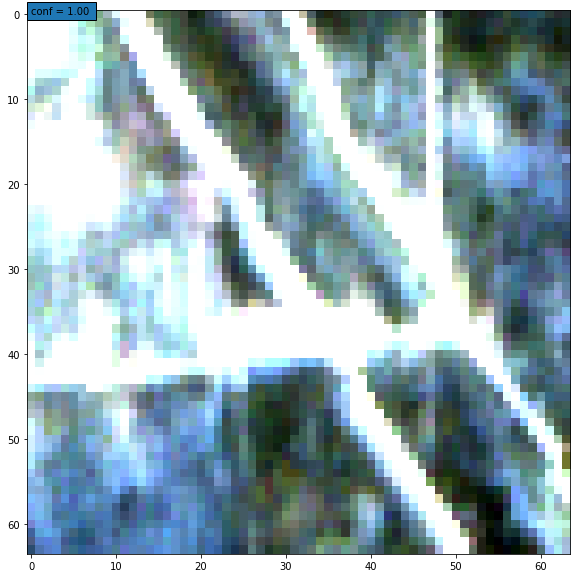

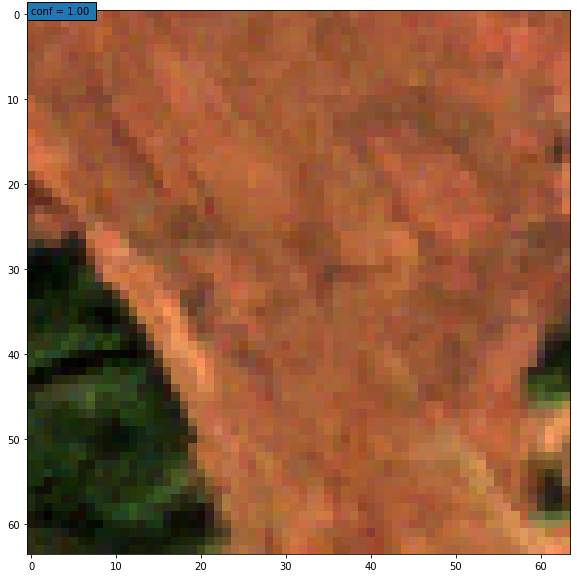

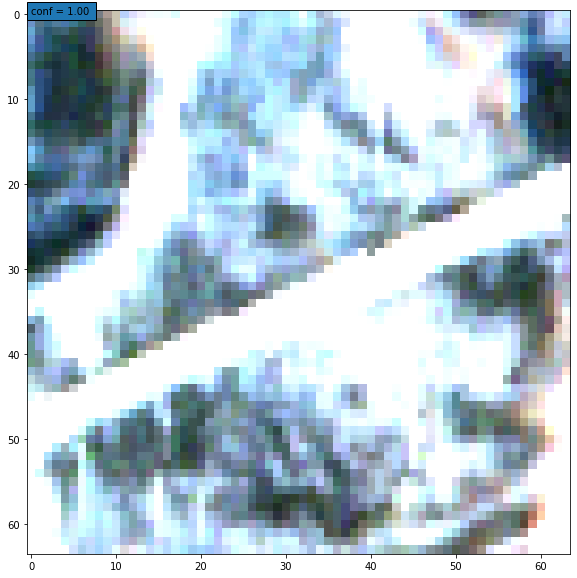

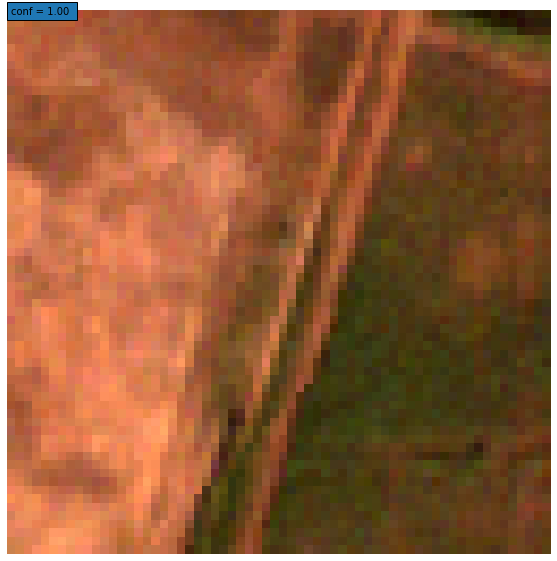

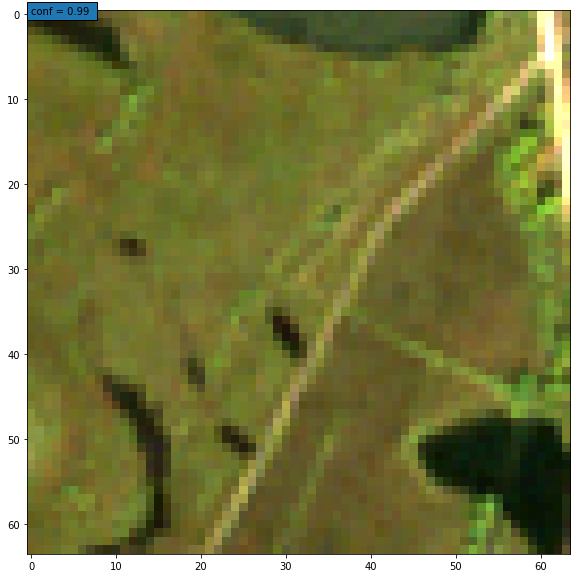

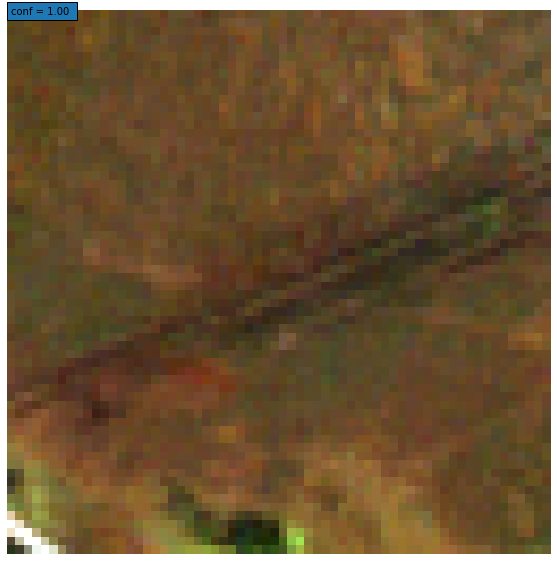

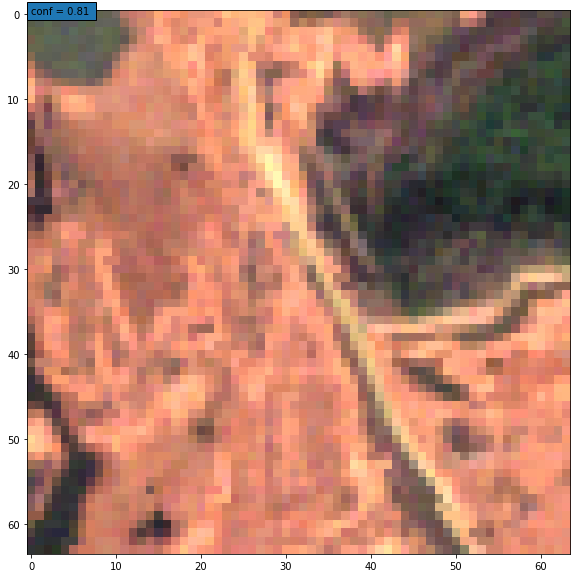

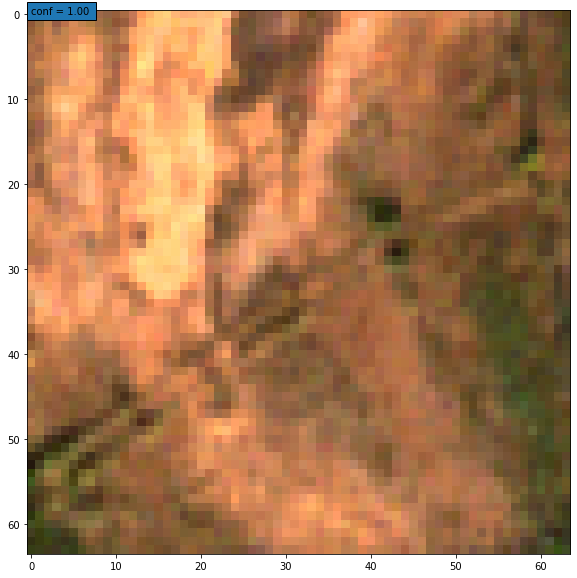

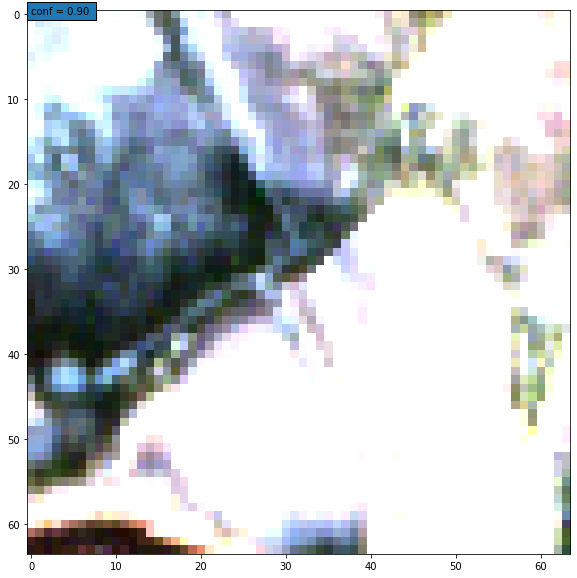

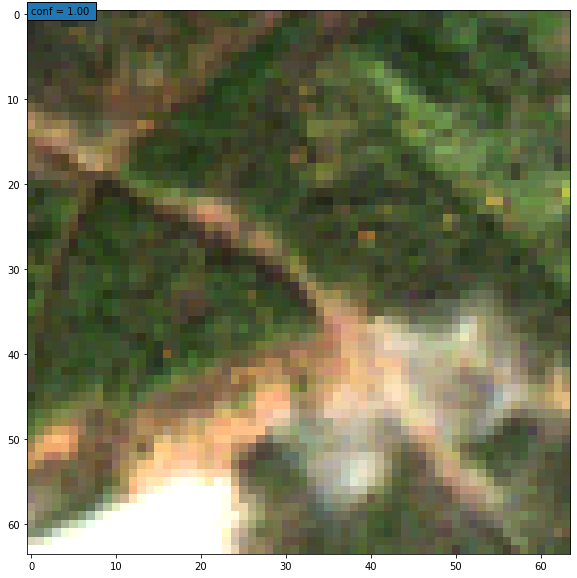

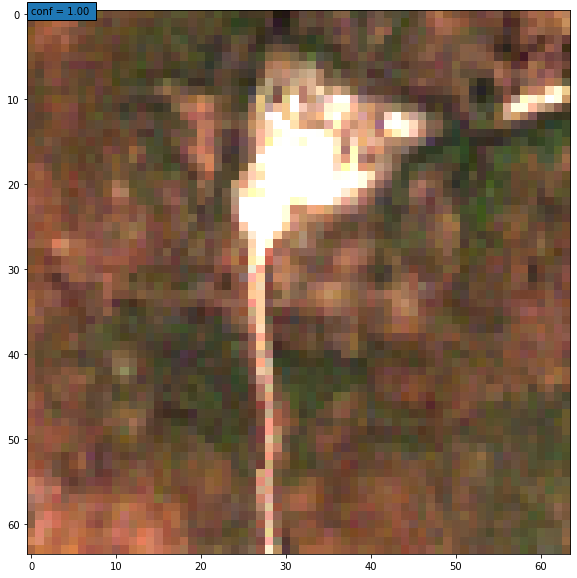

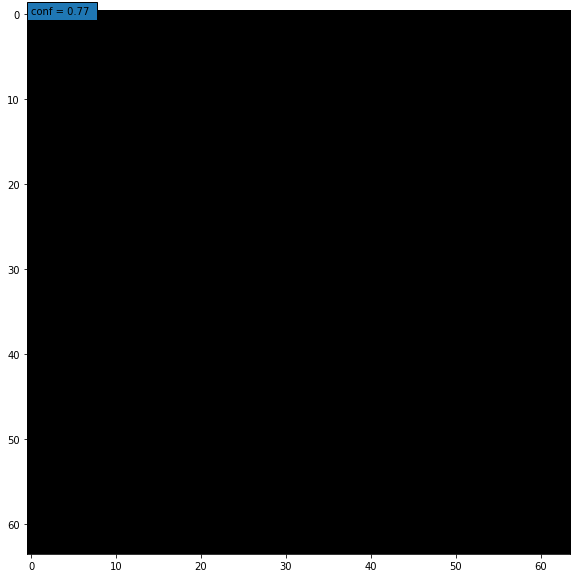

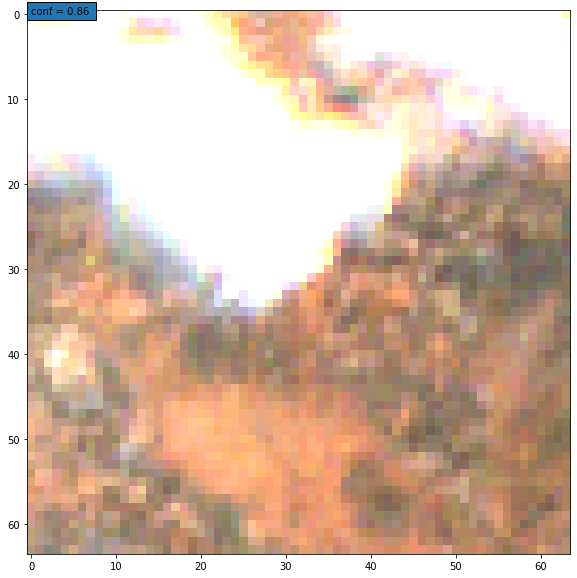

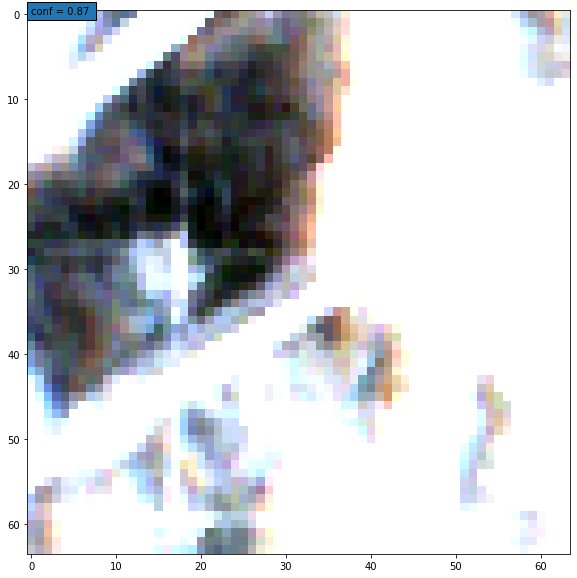

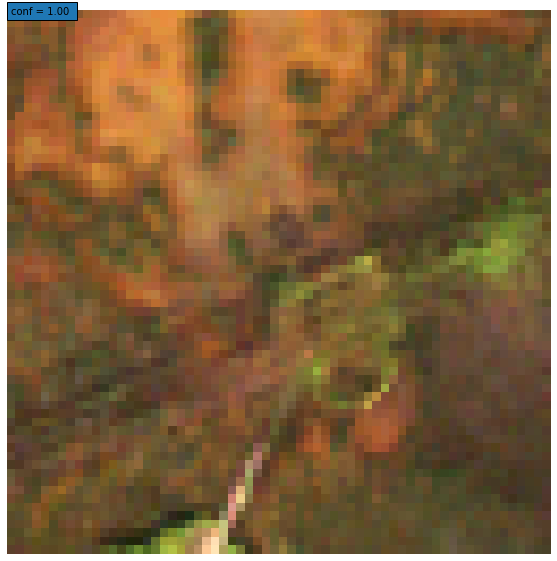

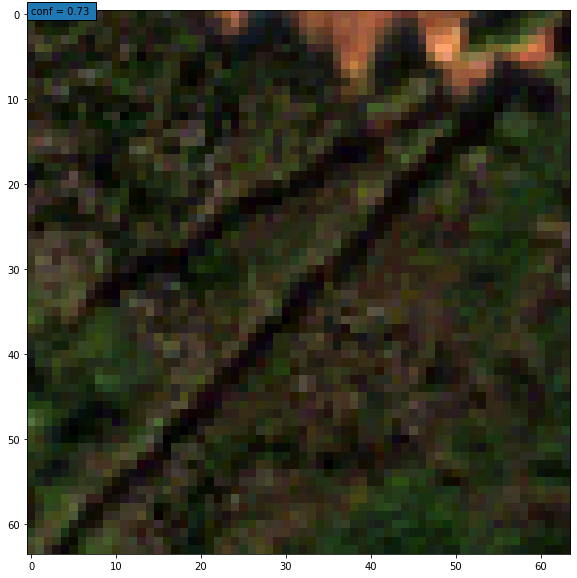

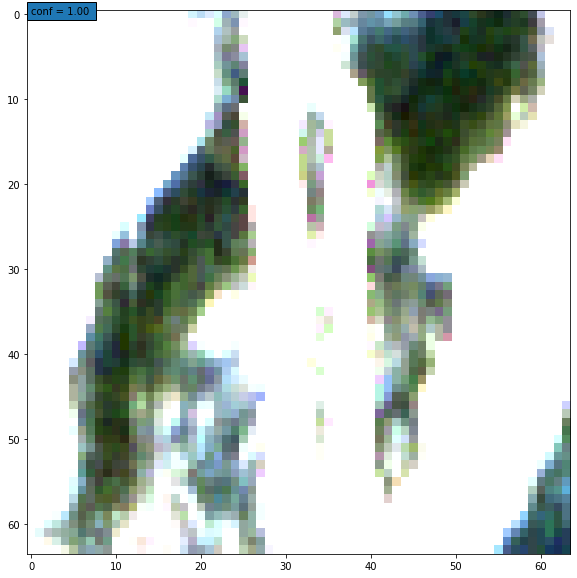

In [318]:
i = 0
for img, conf, tr in zip(imgs[:10000], preds[:10000], true[:10000]):
    if conf > 0.5:
        plt.figure(figsize=(15,10))
        plt.imshow(img)
        plt.text(0, 0, f"conf = %.2f " % conf, bbox=dict(fill=True))
        if i in [11,14,42,44,53]:
            plt.axis('off')
            plt.savefig(f'/content/gdrive/MyDrive/GoodDay/{i}_noconf.png', bbox_inches='tight')
        i+=1

In [281]:
for filename in Path('./pics').glob('*.png'):
    shutil.copy(filename, '/content/gdrive/MyDrive/GoodDay/')

## Segmentation

In [160]:
!pip install catalyst
!pip install segmentation_models_pytorch
from typing import Any, Mapping
import numpy as np
from pathlib import Path
import argparse

from collections import OrderedDict
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from catalyst import dl
from sklearn.model_selection import train_test_split


from read_data1 import load_numpy_gz, load_pickle_gz, read_image, read_timestamp, show_rgb, read_bbox, read_mask_scl
import segmentation_models_pytorch as smp

from IPython.display import clear_output

clear_output()

In [246]:
!rm -r segmentation_data
!rm -r segmentation_data_val/

In [247]:
!mkdir segmentation_data
!mkdir segmentation_data/images
!mkdir segmentation_data/masks

!mkdir segmentation_data_val
!mkdir segmentation_data_val/images
!mkdir segmentation_data_val/masks

In [338]:
from sklearn.model_selection import train_test_split

save_images_dir = Path('segmentation_data/images')
save_images_dir_val = Path('segmentation_data_val/images')

save_masks_dir = Path('segmentation_data/masks')
save_masks_dir_val = Path('segmentation_data_val/masks')

skip_counter = 0

for date_dir in Path('raw_data/spill/').glob("*"):
    train_files, val_files = train_test_split(list(date_dir.glob("*")), test_size=0.2, random_state=142)

    for image in tqdm(train_files):
        try:
            imgs = read_image(image)
            masks = read_mask_scl(image)
        except:
            skip_counter += 1
            continue
        for i in range(imgs.shape[0]):
            if masks[i].sum()==0:
                continue
            np.save(save_images_dir / f"{date_dir.stem}_{image.stem}.npy",
                    (np.clip(imgs[i][:,:,[3, 2, 1]], 0.,1.)*255).astype(np.uint8))
            np.save(save_masks_dir / f"{date_dir.stem}_{image.stem}.npy",
                    (masks[i]*255).astype(np.uint8))
    
    for image in tqdm(val_files):
        try:
            imgs = read_image(image)
            masks = read_mask_scl(image)
        except:
            skip_counter += 1
            continue
        for i in range(imgs.shape[0]):
            if masks[i].sum()==0:
                continue
            np.save(save_images_dir_val / f"{date_dir.stem}_{image.stem}.npy",
                    (np.clip(imgs[i][:,:,[3, 2, 1]], 0.,1.)*255).astype(np.uint8))
            np.save(save_masks_dir_val / f"{date_dir.stem}_{image.stem}.npy",
                    (masks[i]*255).astype(np.uint8))


print(f'{skip_counter} dirs were skipped')

In [249]:
from torch.utils.data import Dataset
import cv2
from pathlib import Path
from torch.utils.data import Dataset


class RADataset(Dataset):

    def __init__(
        self,
        image_filenames,
        transform,
        transform_mask=lambda x: x,
        mask_filenames=None,
        read_image_fn=np.load,
        read_mask_fn=np.load,
    ):
        if mask_filenames is not None and len(image_filenames) != len(mask_filenames):
            raise ValueError(
                "Number of images does not corresponds to number of targets")

        self.images = image_filenames
        self.masks = mask_filenames
        self.read_image = read_image_fn
        self.read_mask = read_mask_fn
        self.transform = transform
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.read_image(self.images[index])
        if self.masks is not None:
            mask = self.read_mask(self.masks[index])

        image = self.transform(image)

        sample = {
            'idx': index,
            'image': image,
        }

        if self.masks is not None:
            mask = self.transform_mask(mask)
            sample['mask'] = mask

        return sample

In [250]:
import torch
import torch.nn.functional as F
from catalyst import dl


class CustomRunner(dl.SupervisedRunner):
    def handle_batch(self, batch):
        x, y = batch['image'], batch['mask']
        logits = self.model(x)

        softm_preds = logits.softmax(dim=2)
        one_hot_targets = F.one_hot(
            y.squeeze(1).to(torch.int64), num_classes=2).permute(0, 3, 1, 2)

        self.batch = {
            "scores": logits,
            'mask': y,
            "softm_preds": softm_preds,
            "one_hot_targets": one_hot_targets,
        }

In [251]:
from typing import Optional, List
from functools import partial

import torch
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from segmentation_models_pytorch.losses._functional import focal_loss_with_logits, soft_jaccard_score, to_tensor
from segmentation_models_pytorch.losses.constants import BINARY_MODE, MULTICLASS_MODE, MULTILABEL_MODE



class FocalLoss(_Loss):

    def __init__(
        self,
        mode: str,
        alpha: Optional[float] = None,
        gamma: Optional[float] = 2.,
        ignore_index: Optional[int] = None,
        reduction: Optional[str] = "mean",
        normalized: bool = False,
        reduced_threshold: Optional[float] = None,
    ):
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super().__init__()

        self.mode = mode
        self.ignore_index = ignore_index
        self.focal_loss_fn = partial(
            focal_loss_with_logits,
            alpha=alpha,
            gamma=gamma,
            reduced_threshold=reduced_threshold,
            reduction=reduction,
            normalized=normalized,
        )

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:

        if self.mode in {BINARY_MODE, MULTILABEL_MODE}:
            y_true = y_true.view(-1)
            y_pred = y_pred.view(-1)

            if self.ignore_index is not None:
                not_ignored = y_true != self.ignore_index
                y_pred = y_pred[not_ignored]
                y_true = y_true[not_ignored]

            loss = self.focal_loss_fn(y_pred, y_true)

        elif self.mode == MULTICLASS_MODE:

            num_classes = y_pred.size(1)
            loss = 0
            # Filter anchors with -1 label from loss computation
            if self.ignore_index is not None:
                not_ignored = y_true != self.ignore_index

            for cls in range(num_classes):
                cls_y_true = (y_true == cls).squeeze(1).long()
                # cls_y_true = y_true[:, cls, ...].long()
                cls_y_pred = y_pred[:, cls, ...]

                if self.ignore_index is not None:
                    cls_y_true = cls_y_true[not_ignored]
                    cls_y_pred = cls_y_pred[not_ignored]

                loss += self.focal_loss_fn(cls_y_pred, cls_y_true)

        return loss


class JaccardLoss(_Loss):

    def __init__(
        self,
        mode: str,
        classes: Optional[List[int]] = None,
        log_loss: bool = False,
        from_logits: bool = True,
        smooth: float = 0.,
        eps: float = 1e-7,
    ):
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(JaccardLoss, self).__init__()

        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, 
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:

        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)
        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

        if self.mode == MULTICLASS_MODE:

            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            y_true = F.one_hot(y_true.long(), num_classes) 
            y_true = y_true.permute(0, 2, 1)

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

        scores = soft_jaccard_score(y_pred, y_true.type(
            y_pred.dtype), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores
        mask = y_true.sum(dims) > 0
        loss *= mask.float()

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()

In [289]:
train_batch_size = 64
valid_batch_size = 64

data_path = Path("./segmentation_data")
image_paths = sorted(
    list((data_path / 'images').glob('*.npy')))

mask_paths = sorted(list((data_path / 'masks').glob('*.npy')))

train_images, valid_images, train_masks, valid_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)


transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])

val_transform = transforms.Compose([
            transforms.ToPILImage(), 
            transforms.ToTensor()
        ])

train_dataset = RADataset(
    image_filenames=train_images,
    mask_filenames=train_masks,
    transform=transform,
    transform_mask=val_transform
)

valid_dataset = RADataset(
    image_filenames=valid_images,
    mask_filenames=valid_masks,
    transform=val_transform,
    transform_mask=val_transform
)

loaders = OrderedDict()

loaders["train"] = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)

loaders["valid"] = DataLoader(
    valid_dataset,
    batch_size=valid_batch_size,
    shuffle=False,
)

model = smp.UnetPlusPlus(encoder_name="resnet18",
                    encoder_weights='imagenet',
                    in_channels=3,
                    classes=2,
                    activation=None)

criterion = {'focal': FocalLoss(mode='multiclass'),
                'dice': JaccardLoss(mode='multiclass')
                }

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=5, gamma=0.1)

runner = CustomRunner(
    input_key="image",
    output_key="scores",
    target_key="mask",
    loss_key="loss"
)

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=25,
    callbacks=[
        dl.CriterionCallback(metric_key="focal_loss",
                                input_key="scores",
                                target_key="mask",
                                criterion_key='focal'),
        dl.CriterionCallback(metric_key="dice_loss",
                                input_key="scores",
                                target_key="mask",
                                criterion_key='dice'),
        dl.MetricAggregationCallback(metric_key="loss",
                                        metrics=["focal_loss", "dice_loss"],
                                        mode="sum"),
        dl.OptimizerCallback(metric_key="loss"),

        dl.IOUCallback(input_key="softm_preds",
                        target_key="one_hot_targets"),
    ],
    logdir='/content/logs/',
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
)

1/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (1/25) dice_loss: 0.5777329820663136 | dice_loss/mean: 0.5777329820663136 | dice_loss/std: 0.0927996034843973 | focal_loss: 0.246301075101044 | focal_loss/mean: 0.246301075101044 | focal_loss/std: 0.23302279353952826 | iou: 0.013700509443879128 | iou/_macro: 0.013700509443879128 | iou/_micro: 0.015392282046377659 | loss: 0.8240340352058411 | lr: 0.01 | momentum: 0.9


1/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (1/25) dice_loss: 0.5107931512073406 | dice_loss/mean: 0.5107931512073406 | dice_loss/std: 0.0035208834256810102 | focal_loss: 507.5181683290351 | focal_loss/mean: 507.5181683290351 | focal_loss/std: 423.3926624771648 | iou: 0.012876038439571857 | iou/_macro: 0.012876038439571857 | iou/_micro: 0.015345278196036816 | loss: 508.0289611816406 | lr: 0.01 | momentum: 0.9
* Epoch (1/25) lr: 0.01 | momentum: 0.9


2/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (2/25) dice_loss: 0.5147555282795473 | dice_loss/mean: 0.5147555282795473 | dice_loss/std: 0.012649027790998704 | focal_loss: 0.11056682467460632 | focal_loss/mean: 0.11056682467460632 | focal_loss/std: 0.03184065415609246 | iou: 0.01373791228979826 | iou/_macro: 0.01373791228979826 | iou/_micro: 0.015412503853440285 | loss: 0.6253223419189453 | lr: 0.01 | momentum: 0.9


2/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (2/25) dice_loss: 0.5107109118433832 | dice_loss/mean: 0.5107109118433832 | dice_loss/std: 0.004880964133040581 | focal_loss: 1.0146566455804027 | focal_loss/mean: 1.0146566455804027 | focal_loss/std: 0.5722312659370606 | iou: 0.013073520734906197 | iou/_macro: 0.013073520734906197 | iou/_micro: 0.015448146499693394 | loss: 1.5253674983978271 | lr: 0.01 | momentum: 0.9
* Epoch (2/25) lr: 0.01 | momentum: 0.9


3/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (3/25) dice_loss: 0.5087218040307749 | dice_loss/mean: 0.5087218040307749 | dice_loss/std: 0.013027648932797058 | focal_loss: 0.09803559871596919 | focal_loss/mean: 0.09803559871596919 | focal_loss/std: 0.04416197863247738 | iou: 0.013730060309171677 | iou/_macro: 0.013730060309171677 | iou/_micro: 0.015416722744703293 | loss: 0.606757402420044 | lr: 0.01 | momentum: 0.9


3/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (3/25) dice_loss: 0.5179930838566382 | dice_loss/mean: 0.5179930838566382 | dice_loss/std: 0.003604876187820935 | focal_loss: 0.39680005812529223 | focal_loss/mean: 0.39680005812529223 | focal_loss/std: 0.2360337132806847 | iou: 0.012761772610247135 | iou/_macro: 0.012761772610247135 | iou/_micro: 0.015420644544064999 | loss: 0.9147931337356567 | lr: 0.01 | momentum: 0.9
* Epoch (3/25) lr: 0.01 | momentum: 0.9


4/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (4/25) dice_loss: 0.4855921197315082 | dice_loss/mean: 0.4855921197315082 | dice_loss/std: 0.037434274260514044 | focal_loss: 0.10284301584153169 | focal_loss/mean: 0.10284301584153169 | focal_loss/std: 0.0340568265908824 | iou: 0.01381993480026722 | iou/_macro: 0.01381993480026722 | iou/_micro: 0.015435448847711086 | loss: 0.588435173034668 | lr: 0.01 | momentum: 0.9


4/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (4/25) dice_loss: 0.5527382672411724 | dice_loss/mean: 0.5527382672411724 | dice_loss/std: 0.03246890607136087 | focal_loss: 0.5144370973688884 | focal_loss/mean: 0.5144370973688884 | focal_loss/std: 0.08133204706579596 | iou: 0.012643937021493912 | iou/_macro: 0.012643937021493912 | iou/_micro: 0.01541931089013815 | loss: 1.0671753883361816 | lr: 0.01 | momentum: 0.9
* Epoch (4/25) lr: 0.01 | momentum: 0.9


5/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (5/25) dice_loss: 0.4568340947508957 | dice_loss/mean: 0.4568340947508957 | dice_loss/std: 0.04832457531307724 | focal_loss: 0.09986701782851794 | focal_loss/mean: 0.09986701782851794 | focal_loss/std: 0.04390081990740213 | iou: 0.01404868345707655 | iou/_macro: 0.01404868345707655 | iou/_micro: 0.015477648936212063 | loss: 0.556701123714447 | lr: 0.01 | momentum: 0.9


5/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (5/25) dice_loss: 0.5029832807559411 | dice_loss/mean: 0.5029832807559411 | dice_loss/std: 0.023096355036882097 | focal_loss: 0.16818007421725004 | focal_loss/mean: 0.16818007421725004 | focal_loss/std: 0.10498616873385001 | iou: 0.013355113565921783 | iou/_macro: 0.013355113565921783 | iou/_micro: 0.015501251444220543 | loss: 0.6711633205413818 | lr: 0.01 | momentum: 0.9
* Epoch (5/25) lr: 0.001 | momentum: 0.9


6/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (6/25) dice_loss: 0.391065427577452 | dice_loss/mean: 0.391065427577452 | dice_loss/std: 0.06473469007829219 | focal_loss: 0.08534059266079937 | focal_loss/mean: 0.08534059266079937 | focal_loss/std: 0.02678203729212328 | iou: 0.014209339395165443 | iou/_macro: 0.014209339395165443 | iou/_micro: 0.015504347160458565 | loss: 0.4764060080051422 | lr: 0.001 | momentum: 0.9


6/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (6/25) dice_loss: 0.47740609958333874 | dice_loss/mean: 0.47740609958333874 | dice_loss/std: 0.05128553587233531 | focal_loss: 0.05498778291986984 | focal_loss/mean: 0.05498778291986984 | focal_loss/std: 0.009753610659364685 | iou: 0.013013776391744614 | iou/_macro: 0.013013776391744614 | iou/_micro: 0.01546703651547432 | loss: 0.5323938727378845 | lr: 0.001 | momentum: 0.9
* Epoch (6/25) lr: 0.001 | momentum: 0.9


7/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (7/25) dice_loss: 0.36582046787137673 | dice_loss/mean: 0.36582046787137673 | dice_loss/std: 0.060829743962442326 | focal_loss: 0.08153748041275212 | focal_loss/mean: 0.08153748041275212 | focal_loss/std: 0.031674700202706095 | iou: 0.014257327653467655 | iou/_macro: 0.014257327653467655 | iou/_micro: 0.015509068965911865 | loss: 0.4473579525947571 | lr: 0.001 | momentum: 0.9


7/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (7/25) dice_loss: 0.47236823109747134 | dice_loss/mean: 0.47236823109747134 | dice_loss/std: 0.056888316847637996 | focal_loss: 0.061850741360951395 | focal_loss/mean: 0.061850741360951395 | focal_loss/std: 0.011497235084369166 | iou: 0.013151504099369049 | iou/_macro: 0.013151504099369049 | iou/_micro: 0.015482359565794468 | loss: 0.534218966960907 | lr: 0.001 | momentum: 0.9
* Epoch (7/25) lr: 0.001 | momentum: 0.9


8/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (8/25) dice_loss: 0.35620609263409647 | dice_loss/mean: 0.35620609263409647 | dice_loss/std: 0.05669612584821561 | focal_loss: 0.09285398068112954 | focal_loss/mean: 0.09285398068112954 | focal_loss/std: 0.028090711387680614 | iou: 0.01419160608202219 | iou/_macro: 0.01419160608202219 | iou/_micro: 0.01549612544476986 | loss: 0.4490600824356079 | lr: 0.001 | momentum: 0.9


8/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (8/25) dice_loss: 0.4721742341819319 | dice_loss/mean: 0.4721742341819319 | dice_loss/std: 0.056252348556555816 | focal_loss: 0.0795397786694823 | focal_loss/mean: 0.0795397786694823 | focal_loss/std: 0.01531656657882637 | iou: 0.013131295330822468 | iou/_macro: 0.013131295330822468 | iou/_micro: 0.015474267303943634 | loss: 0.5517140030860901 | lr: 0.001 | momentum: 0.9
* Epoch (8/25) lr: 0.001 | momentum: 0.9


9/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (9/25) dice_loss: 0.37407719097967995 | dice_loss/mean: 0.37407719097967995 | dice_loss/std: 0.08727024051839993 | focal_loss: 0.11454218391887162 | focal_loss/mean: 0.11454218391887162 | focal_loss/std: 0.04244151683584249 | iou: 0.014325359836220741 | iou/_macro: 0.014325359836220741 | iou/_micro: 0.015514304861426353 | loss: 0.4886193871498108 | lr: 0.001 | momentum: 0.9


9/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (9/25) dice_loss: 0.46674901073418773 | dice_loss/mean: 0.46674901073418773 | dice_loss/std: 0.06047248923136009 | focal_loss: 0.07227787838398832 | focal_loss/mean: 0.07227787838398832 | focal_loss/std: 0.013717181219258476 | iou: 0.01345363724976778 | iou/_macro: 0.01345363724976778 | iou/_micro: 0.01551206037402153 | loss: 0.5390269160270691 | lr: 0.001 | momentum: 0.9
* Epoch (9/25) lr: 0.001 | momentum: 0.9


10/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (10/25) dice_loss: 0.37719167273459864 | dice_loss/mean: 0.37719167273459864 | dice_loss/std: 0.09839536407464472 | focal_loss: 0.11154656493344346 | focal_loss/mean: 0.11154656493344346 | focal_loss/std: 0.04429625251587525 | iou: 0.014503812417387962 | iou/_macro: 0.014503812417387962 | iou/_micro: 0.015550454147160053 | loss: 0.4887382388114929 | lr: 0.001 | momentum: 0.9


10/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (10/25) dice_loss: 0.4617531010248129 | dice_loss/mean: 0.4617531010248129 | dice_loss/std: 0.05700861639189771 | focal_loss: 0.08123230594165116 | focal_loss/mean: 0.08123230594165116 | focal_loss/std: 0.012758258518405605 | iou: 0.01373499445617199 | iou/_macro: 0.01373499445617199 | iou/_micro: 0.015545587055385113 | loss: 0.5429854393005371 | lr: 0.001 | momentum: 0.9
* Epoch (10/25) lr: 0.0001 | momentum: 0.9


11/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (11/25) dice_loss: 0.352495762811073 | dice_loss/mean: 0.352495762811073 | dice_loss/std: 0.07888869831285426 | focal_loss: 0.09356568951554478 | focal_loss/mean: 0.09356568951554478 | focal_loss/std: 0.02973136662864507 | iou: 0.014470459893345833 | iou/_macro: 0.014470459893345833 | iou/_micro: 0.015545384027063847 | loss: 0.4460614323616028 | lr: 0.0001 | momentum: 0.9


11/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (11/25) dice_loss: 0.4656866968256756 | dice_loss/mean: 0.4656866968256756 | dice_loss/std: 0.05450118104853943 | focal_loss: 0.07316011371253762 | focal_loss/mean: 0.07316011371253762 | focal_loss/std: 0.014729938281428908 | iou: 0.013769351877272129 | iou/_macro: 0.013769351877272129 | iou/_micro: 0.015550299547612667 | loss: 0.5388468503952026 | lr: 0.0001 | momentum: 0.9
* Epoch (11/25) lr: 0.0001 | momentum: 0.9


12/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (12/25) dice_loss: 0.3617381381640045 | dice_loss/mean: 0.3617381381640045 | dice_loss/std: 0.11264667811989315 | focal_loss: 0.10457876286538596 | focal_loss/mean: 0.10457876286538596 | focal_loss/std: 0.0338346644689232 | iou: 0.014417189173400402 | iou/_macro: 0.014417189173400402 | iou/_micro: 0.015534636564552784 | loss: 0.46631690859794617 | lr: 0.0001 | momentum: 0.9


12/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (12/25) dice_loss: 0.4693584228024899 | dice_loss/mean: 0.4693584228024899 | dice_loss/std: 0.05107903701867193 | focal_loss: 0.07367557764632031 | focal_loss/mean: 0.07367557764632031 | focal_loss/std: 0.01570352518973321 | iou: 0.013767551630735397 | iou/_macro: 0.013767551630735397 | iou/_micro: 0.015550310723483562 | loss: 0.543034017086029 | lr: 0.0001 | momentum: 0.9
* Epoch (12/25) lr: 0.0001 | momentum: 0.9


13/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (13/25) dice_loss: 0.39166176598632524 | dice_loss/mean: 0.39166176598632524 | dice_loss/std: 0.09980531924988062 | focal_loss: 0.11740606097588442 | focal_loss/mean: 0.11740606097588442 | focal_loss/std: 0.04075294287806158 | iou: 0.014476635493338108 | iou/_macro: 0.014476635493338108 | iou/_micro: 0.01554440800100565 | loss: 0.5090678334236145 | lr: 0.0001 | momentum: 0.9


13/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (13/25) dice_loss: 0.47113579800985395 | dice_loss/mean: 0.47113579800985395 | dice_loss/std: 0.04969121777533112 | focal_loss: 0.07446703473919804 | focal_loss/mean: 0.07446703473919804 | focal_loss/std: 0.01644996221733465 | iou: 0.013743313029408455 | iou/_macro: 0.013743313029408455 | iou/_micro: 0.01554771326482296 | loss: 0.5456027984619141 | lr: 0.0001 | momentum: 0.9
* Epoch (13/25) lr: 0.0001 | momentum: 0.9


14/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (14/25) dice_loss: 0.34934027480295027 | dice_loss/mean: 0.34934027480295027 | dice_loss/std: 0.06952367981049577 | focal_loss: 0.08921980534778877 | focal_loss/mean: 0.08921980534778877 | focal_loss/std: 0.030052664550646067 | iou: 0.014375224709510803 | iou/_macro: 0.014375224709510803 | iou/_micro: 0.015527350828051567 | loss: 0.4385600686073303 | lr: 0.0001 | momentum: 0.9


14/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (14/25) dice_loss: 0.46668386227876235 | dice_loss/mean: 0.46668386227876235 | dice_loss/std: 0.05768498891035794 | focal_loss: 0.06903644123123688 | focal_loss/mean: 0.06903644123123688 | focal_loss/std: 0.013865295000540174 | iou: 0.01370488852262497 | iou/_macro: 0.01370488852262497 | iou/_micro: 0.015543671324849129 | loss: 0.5357202887535095 | lr: 0.0001 | momentum: 0.9
* Epoch (14/25) lr: 0.0001 | momentum: 0.9


15/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (15/25) dice_loss: 0.3596499016311078 | dice_loss/mean: 0.3596499016311078 | dice_loss/std: 0.08769055344429083 | focal_loss: 0.09763162324475023 | focal_loss/mean: 0.09763162324475023 | focal_loss/std: 0.04353169612724707 | iou: 0.014551360160112381 | iou/_macro: 0.014551360160112381 | iou/_micro: 0.015558949671685696 | loss: 0.45728152990341187 | lr: 0.0001 | momentum: 0.9


15/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (15/25) dice_loss: 0.4672417397637969 | dice_loss/mean: 0.4672417397637969 | dice_loss/std: 0.05735464014275717 | focal_loss: 0.06984759671884833 | focal_loss/mean: 0.06984759671884833 | focal_loss/std: 0.014042308128869715 | iou: 0.013722817413508892 | iou/_macro: 0.013722817413508892 | iou/_micro: 0.01554528996348381 | loss: 0.5370893478393555 | lr: 0.0001 | momentum: 0.9
* Epoch (15/25) lr: 1e-05 | momentum: 0.9


16/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (16/25) dice_loss: 0.35867153342255137 | dice_loss/mean: 0.35867153342255137 | dice_loss/std: 0.09815676142197705 | focal_loss: 0.09803814409203129 | focal_loss/mean: 0.09803814409203129 | focal_loss/std: 0.028828682238339204 | iou: 0.014425579458475113 | iou/_macro: 0.014425579458475113 | iou/_micro: 0.015534942038357258 | loss: 0.45670968294143677 | lr: 1e-05 | momentum: 0.9


16/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (16/25) dice_loss: 0.4692947852958753 | dice_loss/mean: 0.4692947852958753 | dice_loss/std: 0.053940427069324046 | focal_loss: 0.07182702338955935 | focal_loss/mean: 0.07182702338955935 | focal_loss/std: 0.01466801845939883 | iou: 0.013750730082392693 | iou/_macro: 0.013750730082392693 | iou/_micro: 0.015548412688076496 | loss: 0.5411218404769897 | lr: 1e-05 | momentum: 0.9
* Epoch (16/25) lr: 1e-05 | momentum: 0.9


17/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (17/25) dice_loss: 0.3529456160536056 | dice_loss/mean: 0.3529456160536056 | dice_loss/std: 0.08740906545773415 | focal_loss: 0.09795907455588375 | focal_loss/mean: 0.09795907455588375 | focal_loss/std: 0.030343266866871867 | iou: 0.01455039530992508 | iou/_macro: 0.01455039530992508 | iou/_micro: 0.015557501465082169 | loss: 0.4509046971797943 | lr: 1e-05 | momentum: 0.9


17/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (17/25) dice_loss: 0.46666024379359866 | dice_loss/mean: 0.46666024379359866 | dice_loss/std: 0.05704479010791488 | focal_loss: 0.07225913699101476 | focal_loss/mean: 0.07225913699101476 | focal_loss/std: 0.014436622804062632 | iou: 0.013775385916233063 | iou/_macro: 0.013775385916233063 | iou/_micro: 0.015551099553704262 | loss: 0.5389193892478943 | lr: 1e-05 | momentum: 0.9
* Epoch (17/25) lr: 1e-05 | momentum: 0.9


18/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (18/25) dice_loss: 0.35563798319552903 | dice_loss/mean: 0.35563798319552903 | dice_loss/std: 0.0886262988835163 | focal_loss: 0.09394615511075297 | focal_loss/mean: 0.09394615511075297 | focal_loss/std: 0.0263982081140725 | iou: 0.014440025202929974 | iou/_macro: 0.014440025202929974 | iou/_micro: 0.015538700856268406 | loss: 0.44958415627479553 | lr: 1e-05 | momentum: 0.9


18/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (18/25) dice_loss: 0.46620156001118784 | dice_loss/mean: 0.46620156001118784 | dice_loss/std: 0.05850267734452294 | focal_loss: 0.0720169058847196 | focal_loss/mean: 0.0720169058847196 | focal_loss/std: 0.014542455985779622 | iou: 0.01376296579837799 | iou/_macro: 0.01376296579837799 | iou/_micro: 0.015549484640359879 | loss: 0.5382184982299805 | lr: 1e-05 | momentum: 0.9
* Epoch (18/25) lr: 1e-05 | momentum: 0.9


19/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (19/25) dice_loss: 0.35675465545178037 | dice_loss/mean: 0.35675465545178037 | dice_loss/std: 0.08840332987766054 | focal_loss: 0.09852391742759732 | focal_loss/mean: 0.09852391742759732 | focal_loss/std: 0.03679931019119658 | iou: 0.014573929831385612 | iou/_macro: 0.014573929831385612 | iou/_micro: 0.015563544817268848 | loss: 0.45527857542037964 | lr: 1e-05 | momentum: 0.9


19/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (19/25) dice_loss: 0.47102749463423943 | dice_loss/mean: 0.47102749463423943 | dice_loss/std: 0.05040887248719081 | focal_loss: 0.07346928513889174 | focal_loss/mean: 0.07346928513889174 | focal_loss/std: 0.015379857671032204 | iou: 0.01377532072365284 | iou/_macro: 0.01377532072365284 | iou/_micro: 0.015550823882222176 | loss: 0.5444967746734619 | lr: 1e-05 | momentum: 0.9
* Epoch (19/25) lr: 1e-05 | momentum: 0.9


20/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (20/25) dice_loss: 0.37330374168855984 | dice_loss/mean: 0.37330374168855984 | dice_loss/std: 0.1083017207274383 | focal_loss: 0.1057431122853027 | focal_loss/mean: 0.1057431122853027 | focal_loss/std: 0.0362893140430029 | iou: 0.014493610709905624 | iou/_macro: 0.014493610709905624 | iou/_micro: 0.015549656935036182 | loss: 0.47904685139656067 | lr: 1e-05 | momentum: 0.9


20/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (20/25) dice_loss: 0.4697857053534499 | dice_loss/mean: 0.4697857053534499 | dice_loss/std: 0.052432404371570804 | focal_loss: 0.07288520305770115 | focal_loss/mean: 0.07288520305770115 | focal_loss/std: 0.014931204994335628 | iou: 0.013769502751529217 | iou/_macro: 0.013769502751529217 | iou/_micro: 0.01555001363158226 | loss: 0.5426709055900574 | lr: 1e-05 | momentum: 0.9
* Epoch (20/25) lr: 1.0000000000000002e-06 | momentum: 0.9


21/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (21/25) dice_loss: 0.37075503056145176 | dice_loss/mean: 0.37075503056145176 | dice_loss/std: 0.0946698674968424 | focal_loss: 0.10243668297394184 | focal_loss/mean: 0.10243668297394184 | focal_loss/std: 0.03749183355326726 | iou: 0.014556169509887695 | iou/_macro: 0.014556169509887695 | iou/_micro: 0.015557917766273022 | loss: 0.4731917083263397 | lr: 1.0000000000000002e-06 | momentum: 0.9


21/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (21/25) dice_loss: 0.4711728466367258 | dice_loss/mean: 0.4711728466367258 | dice_loss/std: 0.05007604248043137 | focal_loss: 0.07361924850824966 | focal_loss/mean: 0.07361924850824966 | focal_loss/std: 0.015574486913744476 | iou: 0.013775629922747612 | iou/_macro: 0.013775629922747612 | iou/_micro: 0.015550796873867512 | loss: 0.5447920560836792 | lr: 1.0000000000000002e-06 | momentum: 0.9
* Epoch (21/25) lr: 1.0000000000000002e-06 | momentum: 0.9


22/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (22/25) dice_loss: 0.36419579713411376 | dice_loss/mean: 0.36419579713411376 | dice_loss/std: 0.0977134272705586 | focal_loss: 0.09938054820397885 | focal_loss/mean: 0.09938054820397885 | focal_loss/std: 0.040371682462357145 | iou: 0.014530930668115616 | iou/_macro: 0.014530930668115616 | iou/_micro: 0.015555682592093945 | loss: 0.4635763466358185 | lr: 1.0000000000000002e-06 | momentum: 0.9


22/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (22/25) dice_loss: 0.46531985222714617 | dice_loss/mean: 0.46531985222714617 | dice_loss/std: 0.05987364456364976 | focal_loss: 0.0714744592031229 | focal_loss/mean: 0.0714744592031229 | focal_loss/std: 0.014177461849586698 | iou: 0.013758044689893723 | iou/_macro: 0.013758044689893723 | iou/_micro: 0.01554873026907444 | loss: 0.5367943048477173 | lr: 1.0000000000000002e-06 | momentum: 0.9
* Epoch (22/25) lr: 1.0000000000000002e-06 | momentum: 0.9


23/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (23/25) dice_loss: 0.36367446717768726 | dice_loss/mean: 0.36367446717768726 | dice_loss/std: 0.09174997847601817 | focal_loss: 0.10130526564661392 | focal_loss/mean: 0.10130526564661392 | focal_loss/std: 0.04084411169538249 | iou: 0.01447049155831337 | iou/_macro: 0.01447049155831337 | iou/_micro: 0.015545724891126156 | loss: 0.46497973799705505 | lr: 1.0000000000000002e-06 | momentum: 0.9


23/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (23/25) dice_loss: 0.46538411182107275 | dice_loss/mean: 0.46538411182107275 | dice_loss/std: 0.06008366126224694 | focal_loss: 0.07162425652580354 | focal_loss/mean: 0.07162425652580354 | focal_loss/std: 0.014435219065936951 | iou: 0.013755826279520988 | iou/_macro: 0.013755826279520988 | iou/_micro: 0.015548358671367168 | loss: 0.5370084047317505 | lr: 1.0000000000000002e-06 | momentum: 0.9
* Epoch (23/25) lr: 1.0000000000000002e-06 | momentum: 0.9


24/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (24/25) dice_loss: 0.36654097208442404 | dice_loss/mean: 0.36654097208442404 | dice_loss/std: 0.10065751584858594 | focal_loss: 0.10480600720709338 | focal_loss/mean: 0.10480600720709338 | focal_loss/std: 0.034198945821369856 | iou: 0.014495113864541054 | iou/_macro: 0.014495113864541054 | iou/_micro: 0.01554765086621046 | loss: 0.47134697437286377 | lr: 1.0000000000000002e-06 | momentum: 0.9


24/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (24/25) dice_loss: 0.46499756007518583 | dice_loss/mean: 0.46499756007518583 | dice_loss/std: 0.06026947498478987 | focal_loss: 0.07187434011003346 | focal_loss/mean: 0.07187434011003346 | focal_loss/std: 0.014218984675309734 | iou: 0.013765367679297924 | iou/_macro: 0.013765367679297924 | iou/_micro: 0.01554943434894085 | loss: 0.5368719100952148 | lr: 1.0000000000000002e-06 | momentum: 0.9
* Epoch (24/25) lr: 1.0000000000000002e-06 | momentum: 0.9


25/25 * Epoch (train):   0%|          | 0/13 [00:00<?, ?it/s]

train (25/25) dice_loss: 0.36008203436192876 | dice_loss/mean: 0.36008203436192876 | dice_loss/std: 0.09359446753104834 | focal_loss: 0.1001675908298353 | focal_loss/mean: 0.1001675908298353 | focal_loss/std: 0.020659009372553744 | iou: 0.014475802890956402 | iou/_macro: 0.014475802890956402 | iou/_micro: 0.015544474124908447 | loss: 0.4602496027946472 | lr: 1.0000000000000002e-06 | momentum: 0.9


25/25 * Epoch (valid):   0%|          | 0/4 [00:00<?, ?it/s]

valid (25/25) dice_loss: 0.465336849388567 | dice_loss/mean: 0.465336849388567 | dice_loss/std: 0.06072708526952701 | focal_loss: 0.07097594024052899 | focal_loss/mean: 0.07097594024052899 | focal_loss/std: 0.014056180925119384 | iou: 0.013741159811615944 | iou/_macro: 0.013741159811615944 | iou/_micro: 0.015546632930636406 | loss: 0.5363128185272217 | lr: 1.0000000000000002e-06 | momentum: 0.9
* Epoch (25/25) lr: 1.0000000000000002e-07 | momentum: 0.9
Top best models:
/content/logs/checkpoints/train.6.pth	0.5324


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([64, 2, 64, 64])
0
1
2
3
4
5
6
7
8
9
10
11


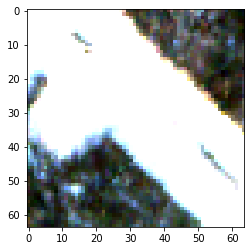

12
13
14
15


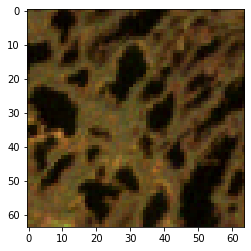

16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


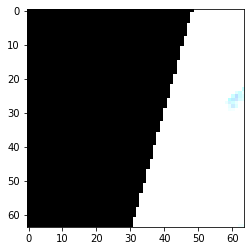

39
40
41
42
43
44
45


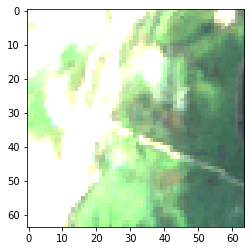

 25%|██▌       | 1/4 [00:00<00:02,  1.17it/s]

46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
torch.Size([64, 2, 64, 64])
0
1
2
3
4
5
6


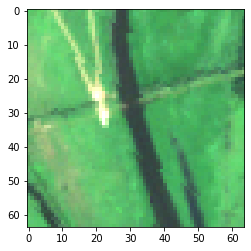

7
8


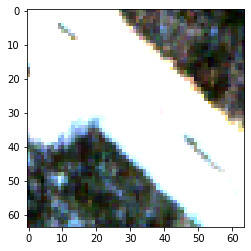

9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


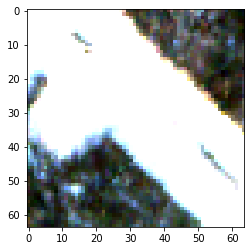

35
36
37
38


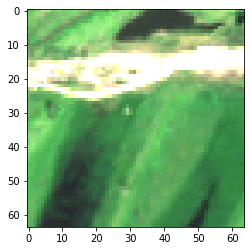

 50%|█████     | 2/4 [00:01<00:01,  1.17it/s]

39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
torch.Size([64, 2, 64, 64])
0
1
2
3
4
5


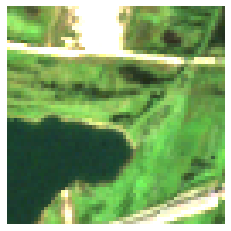

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


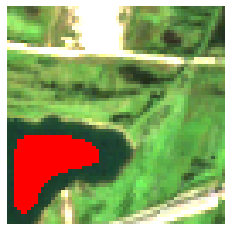

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


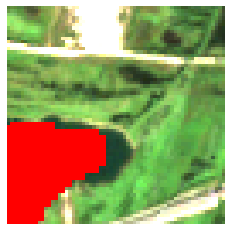

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


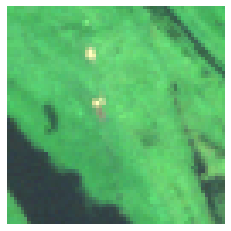

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


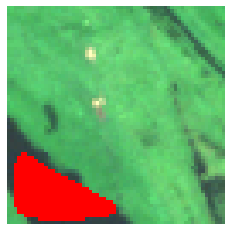

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


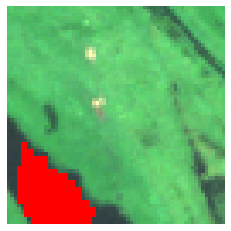

23
24
25
26


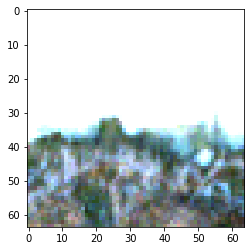

27
28
29
30


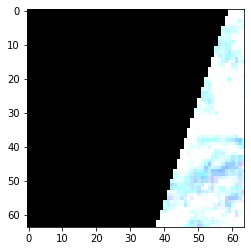

31
32
33
34
35


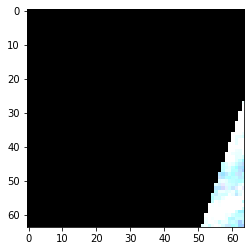

36
37
38
39
40
41
42
43


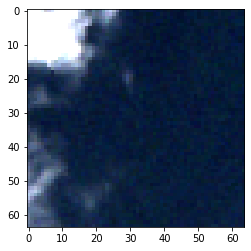

44
45
46


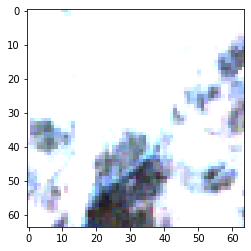

47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


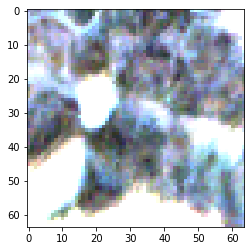

62
63


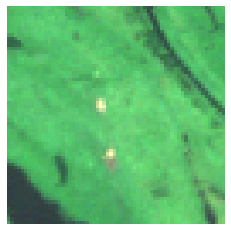

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


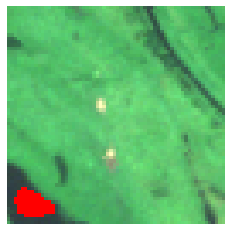

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


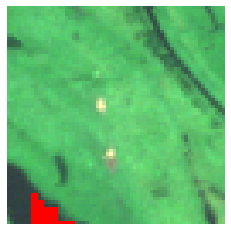

100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

torch.Size([14, 2, 64, 64])
0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [293]:
preds = []
imgs = []
true = []
model.cuda()
with torch.no_grad():
    j = 0
    for data_dict in tqdm(loaders['valid'], position=0):
        j+=1
        # imgs.append(X_batch[0].numpy().transpose((1, 2, 0))
        X_batch = data_dict['image']
        masks = data_dict['mask']
        X_batch = X_batch.to(DEVICE)
        pred = model(X_batch.float())
        print(pred.shape)
        for i in range(pred.shape[0]):
            print(i)
            
            if np.sum(pred[i].softmax(dim=0).argmax(0).cpu().detach().numpy()) != 0:
                img = data_dict['image'][i].numpy().transpose((1,2,0))
                plt.imshow(img)
                if i in [5,22,63]:
                    plt.axis('off')
                    plt.savefig(f'/content/gdrive/MyDrive/GoodDay/{i+j}_img.png', bbox_inches='tight')   
                plt.show()
                if i in [5,22,63]:
                    mask = pred[i].softmax(dim=0).argmax(0).cpu().detach().numpy() == 1
                    img_pred = img.copy()
                    img_pred[mask] = [255,0,0]
                    plt.imshow(img_pred)
                    plt.axis('off')
                    plt.savefig(f'/content/gdrive/MyDrive/GoodDay/{i+j}_pred.png', bbox_inches='tight')   
                plt.show()
                if i in [5,22,63]:
                    mask = masks[i][0] == 1
                    img_pred = img.copy()
                    img_pred[mask] = [255,0,0]
                    plt.imshow(img_pred)
                    plt.axis('off')
                    plt.savefig(f'/content/gdrive/MyDrive/GoodDay/{i+j}_true.png', bbox_inches='tight') 
                plt.show()



In [28]:
import segmentation_models_pytorch as smp
from PIL import Image

val_transform = transforms.Compose([ 
            transforms.Resize([64,64]),
            transforms.ToTensor()
        ])
model = smp.UnetPlusPlus(encoder_name="resnet18",
                    encoder_weights='imagenet',
                    in_channels=3,
                    classes=2,
                    activation=None)
model.eval()


checkpoint = torch.load("/content/logs/checkpoints/best.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

img = Image.open('/content/tg_data/58.0-61.0.jpg')
x = val_transform(img).unsqueeze(0)

with torch.no_grad():
    oil_square = model(x)[0].softmax(axis=0).argmax(axis=0).sum()
oil_square

tensor(147)

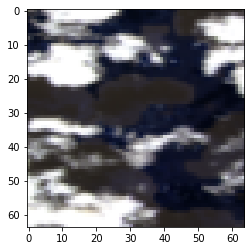

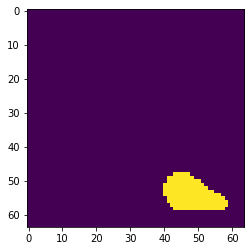

In [27]:
plt.imshow(x[0].numpy().transpose((1,2,0)))
plt.show()
plt.imshow(pred)
plt.show()